In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "dim_reduction"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

**Warning**
>Reducing dimensionality does cause some information loss, just like compressing an
image to JPEG can degrade its quality, so even though it will speed up training, it may
make your system perform slightly worse. It also makes your pipelines a bit more complex
and thus harder to maintain. Therefore, I recommend you first try to train your system with
the original data before considering using dimensionality reduction. In some cases,
reducing the dimensionality of the training data may filter out some noise and unnecessary
details and thus result in higher performance, but in general it won’t; it will just speed up
training.

* Many machine learning problems involve **thousands or millions of features per training instance**.
* A very high number of features leads to:

  * **Extremely slow training**
  * **Greater difficulty in finding a good solution**
* This phenomenon is known as the **curse of dimensionality**.
* In many real-world problems, it is possible to **significantly reduce the number of features**.
* Dimensionality reduction can turn an **intractable problem into a tractable one**.
* Example: **MNIST dataset**

  * Pixels on the **image borders are almost always white**.
  * These border pixels can be **removed without losing useful information**.
  * Previous analysis (Chapter 7) shows these pixels are **unimportant for classification**.
* **Neighboring pixels are often highly correlated**.

  * Merging neighboring pixels (e.g., taking the **mean of their intensities**) preserves most of the information.
* Benefits of dimensionality reduction:

  * **Speeds up model training**
  * **Reduces computational cost**
  * **Simplifies the learning problem**
* Dimensionality reduction is also **extremely useful for data visualization**.
* Reducing dimensions to **2D or 3D** allows:

  * Plotting a **condensed view of high-dimensional data**
  * Visual detection of **patterns such as clusters**
* Visualization helps in:

  * Gaining **intuitive insights** into the data
  * **Communicating results** to non–data scientists
  * Supporting **decision makers** who rely on model outcomes
* The chapter structure:

  * First, discusses the **curse of dimensionality** and behavior of **high-dimensional spaces**
  * Then introduces **two main approaches** to dimensionality reduction:

    * **Projection**
    * **Manifold learning**
* The chapter covers **three popular dimensionality reduction techniques**:

  * **Principal Component Analysis (PCA)**
  * **Random Projection**
  * **Locally Linear Embedding (LLE)**


# The Curse of Dimensionality

* Human intuition is adapted to **3-dimensional space**, so it **fails in high-dimensional spaces**.

* Even a **4D hypercube** is very hard to visualize mentally.

* Visualizing objects like:

  * a **200-dimensional ellipsoid**
  * embedded in a **1,000-dimensional space**
    is practically impossible.

* Many properties behave **very differently** as dimensionality increases.

* Example: **Points near the border**

  * In a **2D unit square (1 × 1)**:

    * Probability that a random point is within **0.001 of a border ≈ 0.4%**
    * Random points are rarely “extreme” along any dimension.
  * In a **10,000-dimensional unit hypercube**:

    * Probability of being within **0.001 of a border > 99.999999%**
    * Most points lie **very close to the border**.

* Conclusion:

  * In high dimensions, **almost all points are extreme along at least one dimension**.

* Example: **Distance between random points**

  * In a **2D unit square**:

    * Average distance between two random points ≈ **0.52**
  * In a **3D unit cube**:

    * Average distance ≈ **0.66**
  * In a **1,000,000-dimensional unit hypercube**:

    * Average distance ≈ **408.25**

* This is counterintuitive because:

  * All points lie inside a unit hypercube
  * Yet distances grow very large

* Reason:

  * High-dimensional spaces contain **enormous amounts of space**.

* Consequences of high dimensionality:

  * High-dimensional datasets tend to be **very sparse**.
  * Most training instances are **far away from each other**.
  * A new instance will likely be:

    * Far from all training instances
    * Outside dense regions of the data

* This leads to:

  * **Unreliable predictions**
  * Heavy reliance on **extrapolation** rather than interpolation

* Overall effect:

  * The **risk of overfitting increases** as the number of dimensions grows.

* Theoretical solution:

  * **Increase the size of the training set** to improve data density.

* Practical limitation:

  * Required number of training instances grows **exponentially** with the number of dimensions.

* Example:

  * With **100 features**, each ranging from **0 to 1**:

    * To have training instances within **0.1 distance** of each other on average:

      * You would need **more instances than atoms in the observable universe**

* Conclusion:

  * Increasing dataset size is **not a practical solution** to the curse of dimensionality.
  * Dimensionality reduction becomes **essential**, not optional.


# Main Approaches for Dimensionality Reduction

Before we dive into specific dimensionality reduction algorithms, let’s take a
look at the two main approaches to reducing dimensionality: 
- projection
- manifold learning.


## Projection

In [4]:
# extra code

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

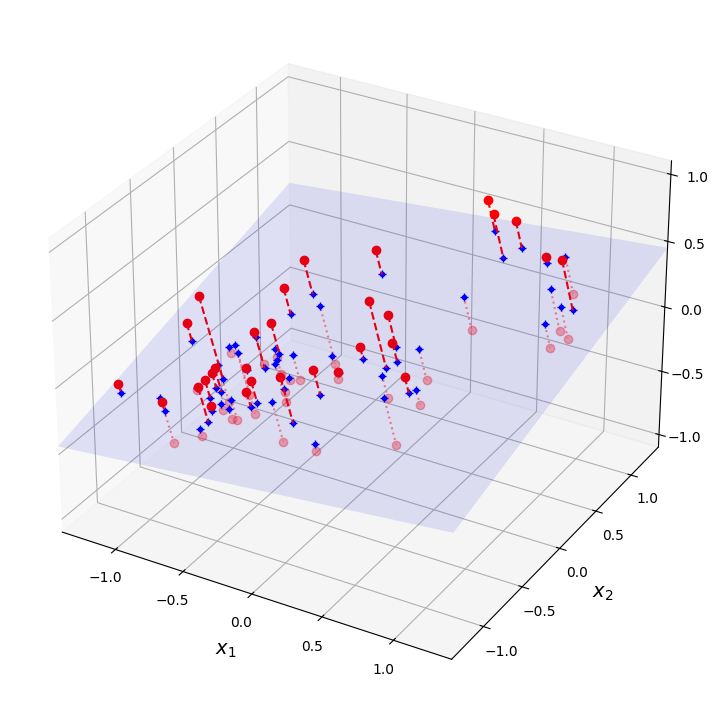

In [5]:
# extra code – this cell generates and saves Figure 8–2

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

save_fig("dataset_3d_plot", tight_layout=False)
plt.show()

* In most real-world datasets, training instances are **not uniformly distributed** across all dimensions.

* Common real-world data properties:

  * Many features are **almost constant**
  * Many features are **highly correlated** (e.g., MNIST pixels)

* Because of this:

  * Data points lie **on or near a much lower-dimensional subspace**
  * Even though the data exists in a high-dimensional space

* A **subspace** is a lower-dimensional structure embedded inside a higher-dimensional space.

* Example:

  * A **3D dataset** where points are visualized as small spheres
  * All points lie **close to a 2D plane**

* This plane represents a **2D subspace** of the original **3D space**.

* Key observation:

  * Although data is stored in **3 dimensions**
  * Its **intrinsic dimensionality** is actually **2**

* Dimensionality reduction via **projection**:

  * Each training instance is **projected perpendicularly** onto the lower-dimensional subspace
  * Projection is shown by **dashed lines** from points to the plane

* After projection:

  * The dataset becomes **2D instead of 3D**
  * Dimensionality is successfully reduced

* Resulting features:

  * The new axes are **not the original x, y, z**
  * They are **new features** (denoted as **z₁ and z₂**)
  * These features are:

    * Coordinates of the projected points on the plane
    * Linear combinations of the original features

* Key takeaway:

  * Dimensionality reduction works by:

    * Identifying a **lower-dimensional subspace**
    * **Projecting data** onto that subspace
  * This preserves most of the useful information while:

    * Reducing noise
    * Reducing complexity
    * Making learning easier


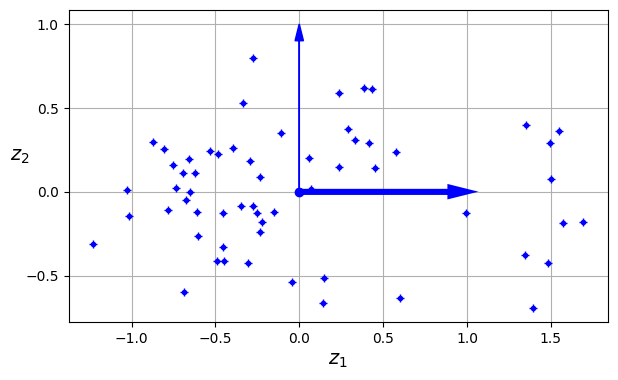

In [6]:
# extra code – this cell generates and saves Figure 8–3

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)
save_fig("dataset_2d_plot")

## Manifold Learning

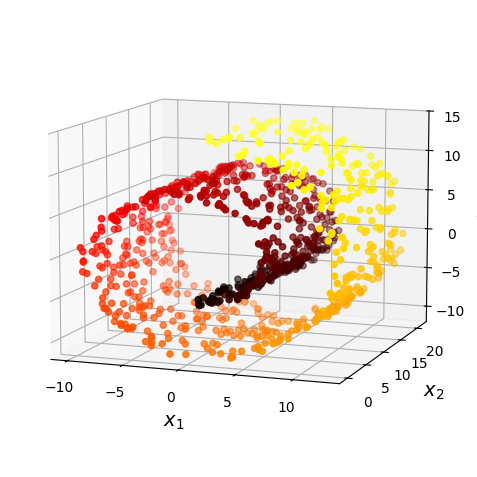

In [7]:
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
# extra code – this cell generates and saves Figure 8–4

from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)
save_fig("swiss_roll_plot")
plt.show()

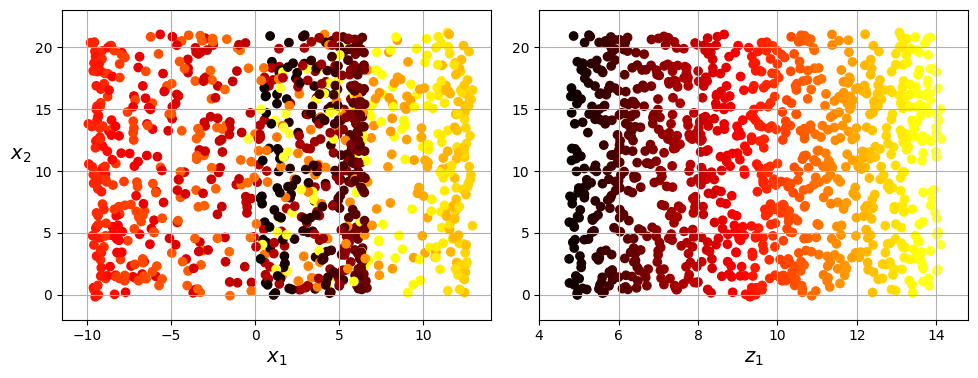

In [8]:
# extra code – this cell generates and saves plots for Figure 8–5

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

* **Projection is not always sufficient** for dimensionality reduction.

* In some datasets, the lower-dimensional structure:

  * **Twists and curves**
  * Is not well represented by a flat linear subspace

* Example: **Swiss roll dataset**

  * A classic toy dataset used to illustrate nonlinear structure
  * Appears 3D, but intrinsically has fewer dimensions

* Problem with simple projection:

  * Projecting the Swiss roll onto a plane (e.g., dropping one coordinate like `x`)
  * Causes **different layers of the roll to overlap**
  * This **destroys the true structure** of the data

* Effect:

  * Distinct points in the original space become indistinguishable
  * Important relationships between points are lost

* Desired approach:

  * **Unroll the Swiss roll**
  * Recover the underlying **2D structure**
  * Preserve neighborhood relationships

* Definition: **Manifold**

  * A **2D manifold** is a 2D shape that can be **bent or twisted** in a higher-dimensional space
  * General case:

    * A **d-dimensional manifold** embedded in an **n-dimensional space**
    * Condition: `d < n`
    * Locally resembles a **d-dimensional hyperplane**

* Swiss roll specifics:

  * `d = 2`, `n = 3`
  * Locally looks like a 2D plane
  * Globally rolled into the third dimension

* **Manifold learning**

  * A class of dimensionality reduction algorithms
  * Goal: **model the manifold** on which the data lies

* Based on the **manifold assumption (manifold hypothesis)**:

  * Most real-world high-dimensional datasets lie close to a **much lower-dimensional manifold**
  * This assumption is **frequently confirmed empirically**

* Intuition using **MNIST dataset**:

  * Handwritten digits share strong constraints:

    * Connected strokes
    * White borders
    * Centered shapes
  * Randomly generated images:

    * Almost never resemble digits
  * Conclusion:

    * The true **degrees of freedom** for digit images are far fewer than pixel count
    * These constraints compress data into a **lower-dimensional manifold**

* Additional implicit assumption:

  * Learning tasks (classification/regression) become **simpler in manifold space**

* Example (Swiss roll classification):

  * In original **3D space**:

    * Decision boundary is **complex**
  * In **2D unrolled manifold space**:

    * Decision boundary becomes a **straight line**

* Important caveat:

  * This simplification **does not always hold**

* Counterexample:

  * Decision boundary defined by:

    * `x = 5`
  * In **3D space**:

    * Simple boundary (a vertical plane)
  * In **2D unrolled space**:

    * Boundary becomes **complex**
    * Appears as **multiple disconnected line segments**

* Key takeaway:

  * Dimensionality reduction:

    * Usually **speeds up training**
    * **Does not guarantee** a better or simpler model
  * Effectiveness depends heavily on:

    * Dataset structure
    * Task characteristics

* Summary so far:

  * Curse of dimensionality causes sparsity and poor generalization
  * Dimensionality reduction helps combat it
  * **Manifold learning is especially effective when the manifold assumption holds**

* Next focus:

  * Study of **popular dimensionality reduction algorithms**


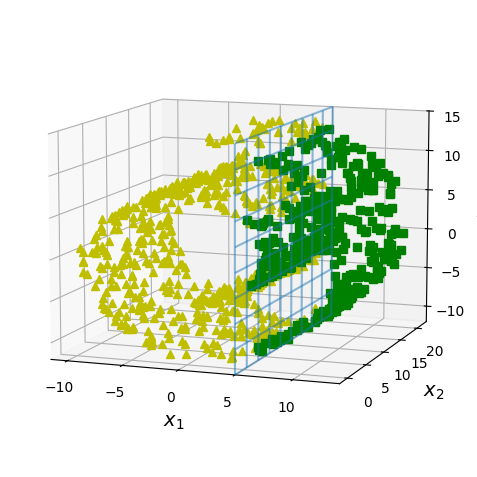

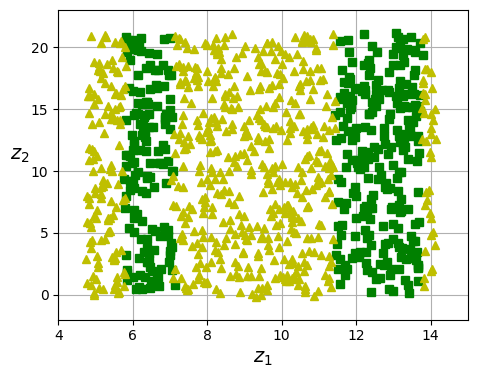

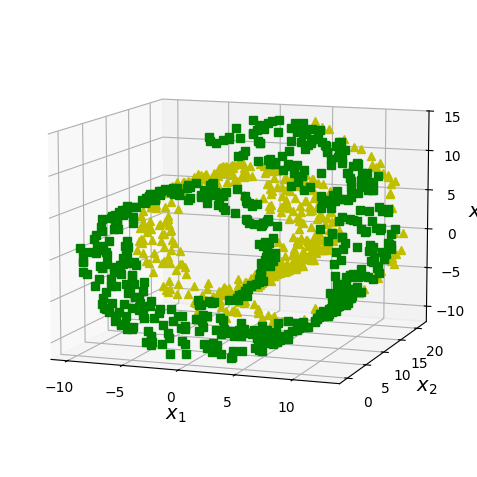

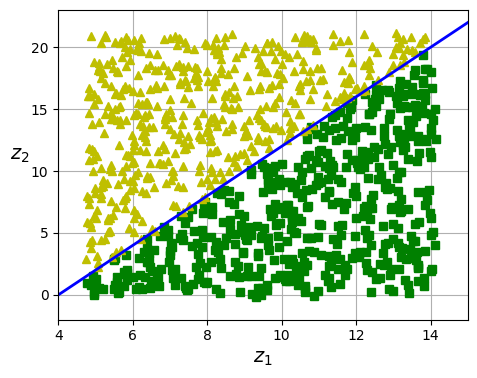

In [9]:
# extra code – this cell generates and saves plots for Figure 8–6
    
axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax, axes)
save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
save_fig("manifold_decision_boundary_plot2")
plt.show()

positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x_1$", rotation=0)
ax.set_ylabel("$x_2$", rotation=0)
ax.set_zlabel("$x_3$", rotation=0)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.plot([4, 15], [0, 22], "b-", linewidth=2)
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
save_fig("manifold_decision_boundary_plot4")
plt.show()

# PCA

>**Principal component analysis (PCA)** is by far the most popular
dimensionality reduction algorithm. First it identifies the hyperplane that lies
closest to the data, and then it projects the data onto it

## Preserving the Variance

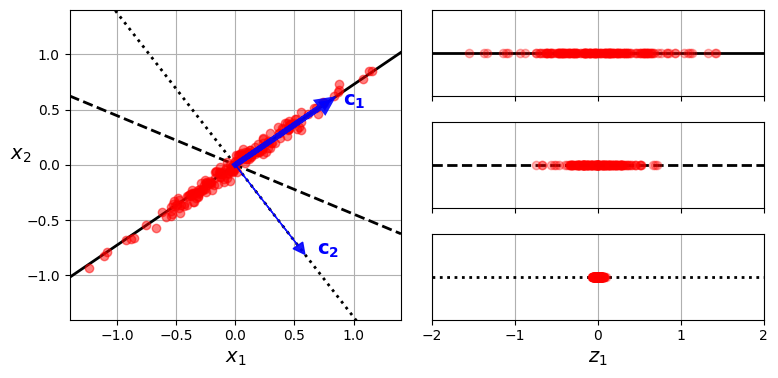

In [10]:
# extra code – this cell generates and saves Figure 8–7

angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2)
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2)
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")
plt.grid()

save_fig("pca_best_projection_plot")
plt.show()

* Before performing **projection-based dimensionality reduction**, the **choice of hyperplane (subspace)** is critical.

* Different projection axes can lead to **very different results**, even for the same dataset.

* Example setup:

  * A **2D dataset** is shown
  * Three different **1D hyperplanes (axes)** are considered for projection

* Each axis produces a different **1D projection** of the data.

* Comparison of projections:

  * **Solid line axis**:

    * Preserves the **maximum variance**
    * Data points are well spread out after projection
  * **Dotted line axis**:

    * Preserves **very little variance**
    * Most points collapse close to each other
    * Large amount of information is lost
  * **Dashed line axis**:

    * Preserves an **intermediate amount of variance**

* Key principle:

  * The best projection is the one that **maximizes variance** of the projected data.

* Intuition:

  * High variance means:

    * Data is more spread out
    * Important structure is better preserved
  * Low variance means:

    * Data collapses
    * Information is lost

* Alternative interpretation:

  * The best axis is the one that **minimizes the reconstruction error**.

* Reconstruction error:

  * Defined as the **mean squared distance** between:

    * Original data points
    * Their projections onto the chosen axis

* Objective equivalence:

  * **Maximizing variance** of projections
    ⇔ **Minimizing mean squared reconstruction error**

* This core idea forms the basis of:

  * **Principal Component Analysis (PCA)**


## Principal Components

>For each principal component, PCA finds a zero-centered unit vector pointing in the
direction of the PC. Since two opposing unit vectors lie on the same axis, the direction of
the unit vectors returned by PCA is not stable: if you perturb the training set slightly and
run PCA again, the unit vectors may point in the opposite direction as the original vectors.
However, they will generally still lie on the same axes. In some cases, a pair of unit
vectors may even rotate or swap (if the variances along these two axes are very close), but
the plane they define will generally remain the same.

* **Principal Component Analysis (PCA)** identifies:

  * The **axis that explains the maximum variance** in the training set

* In the earlier 2D example:

  * The **first principal component (PC₁)** is the solid line
  * It captures the **largest possible variance**

* PCA then finds:

  * A **second axis**, orthogonal to the first
  * This axis captures the **maximum remaining variance**

* In a 2D dataset:

  * There is only **one possible orthogonal direction**

* In higher-dimensional datasets:

  * PCA continues finding:

    * 3rd axis orthogonal to the first two
    * 4th axis orthogonal to the first three
    * And so on
  * Total number of PCs = **number of original dimensions**

* Definition:

  * The **i-th axis** found by PCA is called the **i-th principal component (PCᵢ)**

* Interpretation using figures:

  * In the 2D example:

    * **PC₁** lies along vector **c₁**
    * **PC₂** lies along vector **c₂**
  * In the 3D dataset example:

    * **PC₁ and PC₂** lie on the **projection plane**
    * **PC₃** is the axis **orthogonal to that plane**
  * After projecting to 2D:

    * **PC₁ corresponds to z₁**
    * **PC₂ corresponds to z₂**

* Key property of principal components:

  * Each PC is:

    * A **unit vector**
    * **Orthogonal** to all other PCs
    * Ordered by **descending explained variance**

* Computing principal components:

  * PCA uses **Singular Value Decomposition (SVD)**
  * Given the centered training set matrix `X`:

    ```
    X = U Σ Vᵀ
    ```

* Meaning of matrices:

  * `U`:

    * Contains left singular vectors
  * `Σ` (Sigma):

    * Diagonal matrix of singular values
    * Related to variance explained by each PC
  * `Vᵀ`:

    * Contains right singular vectors
  * `V`:

    * Columns are the **principal components**

* Principal components matrix:

  ```
  V = | c₁  c₂  …  cₙ |
  ```

* Each column `cᵢ`:

  * Is a **unit vector**
  * Defines the direction of the **i-th principal component**

* Practical usage:

  * Use SVD to compute all PCs
  * Select the first `k` PCs:

    * Those that explain the most variance
  * Project data onto these PCs for dimensionality reduction


---

**warning**
>PCA assumes that the dataset is centered around the origin. As you will see, Scikit-Learn’s
PCA classes take care of centering the data for you. If you implement PCA yourself (as in
the preceding example), or if you use other libraries, don’t forget to center the data first.


In [11]:
import numpy as np

# X = [...]  # the small 3D dataset was created earlier in this notebook
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

Note: in principle, the SVD factorization algorithm returns three matrices, **U**, **Σ** and **V**, such that **X** = **UΣV**<sup>⊺</sup>, where **U** is an _m_ × _m_ matrix, **Σ** is an _m_ × _n_ matrix, and **V** is an _n_ × _n_ matrix. But the `svd()` function returns **U**, **s** and **V**<sup>⊺</sup> instead. **s** is the vector containing all the values on the main diagonal of the top _n_ rows of **Σ**. Since **Σ** is full of zeros elsewhere, your can easily reconstruct it from **s**, like this:

In [12]:
# extra code – shows how to construct Σ from s
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)

## Projecting Down to d Dimensions

* After identifying all **principal components**, dimensionality can be reduced to **d dimensions**.

* This is done by:

  * Projecting the dataset onto the **hyperplane spanned by the first d principal components**.

* Why choose the first d PCs:

  * They are ordered by **explained variance**
  * The first d PCs preserve the **maximum possible variance**
  * This minimizes information loss

* Example:

  * A **3D dataset** is projected onto:

    * The **2D plane** defined by **PC₁ and PC₂**
  * Since these PCs capture most of the variance:

    * The 2D projection looks **very similar** to the original 3D dataset

* Projection mechanics:

  * Let:

    * `X` = centered training set matrix
    * `V` = matrix of all principal components
  * Define:

    * `W_d` = matrix containing the **first d columns of V**

* Projection formula (dimensionality reduction):

  ```
  X_d-proj = X · W_d
  ```

* Result:

  * `X_d-proj` has:

    * `d` features instead of the original `n`
    * Maximum variance preserved among all possible d-dimensional projections

* Practical Python implementation:

  * Extract the first `d` principal components:

    ```
    W2 = Vt[:2].T
    ```

  * Project the centered data:

    ```
    X2D = X_centered @ W2
    ```

* Key takeaways:

  * PCA-based projection:

    * Is **simple and efficient**
    * Works for **any target dimension d**
  * The reduced dataset:

    * Retains the most important structure
    * Is faster to train on
    * Is easier to visualize and analyze


In [13]:
W2 = Vt[:2].T
X2D = X_centered @ W2

In [15]:
# X2D

## Using Scikit-Learn

- Scikit-Learn’s PCA class uses SVD to implement PCA, just like we did
earlier in this chapter
- note that it
automatically takes care of centering the data
- After fitting the PCA transformer to the dataset, its **components_** attribute
holds the transpose of W : it contains one row for each of the first d principal
components

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [17]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

## Explained Variance Ratio

- Another useful piece of information is the explained variance ratio of each
principal component, available via the explained_variance_ratio_ variable.
The ratio indicates the proportion of the dataset’s variance that lies along
each principal component. For example, let’s look at the explained variance
ratios of the first two components of the 3D dataset represented in Figure 8-2:
- This output tells us that about 76% of the dataset’s variance lies along the
first PC, and about 15% lies along the second PC. This leaves about 9% for
the third PC, so it is reasonable to assume that the third PC probably carries
little information

In [18]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

In [19]:
1 - pca.explained_variance_ratio_.sum()  # extra code

np.float64(0.09028309326742034)

## Choosing the Right Number of Dimensions

In [20]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154

In [21]:
d

np.int64(154)

In [22]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [23]:
pca.n_components_

np.int64(154)

In [24]:
pca.explained_variance_ratio_.sum()  # extra code

np.float64(0.9501960192613034)

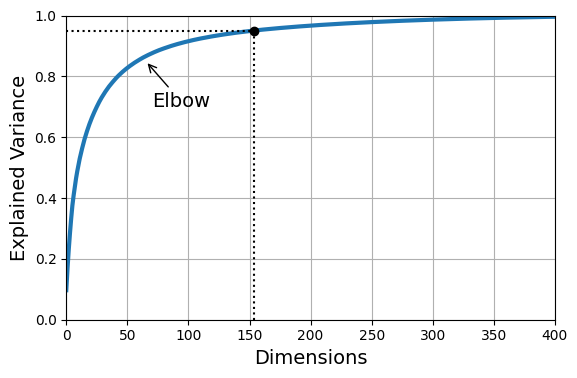

In [25]:
# extra code – this cell generates and saves Figure 8–8

plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

* Instead of **arbitrarily choosing the target dimensionality**, a better strategy is to:

  * Select the number of dimensions that preserve a **desired fraction of variance**
  * Common choice: **95% of the variance**

* Exception:

  * For **data visualization**, dimensionality is typically reduced to **2 or 3**, regardless of variance preserved

* PCA provides:

  * **Explained variance ratio** for each principal component
  * This indicates how much variance each component captures

* To determine required dimensionality:

  * Compute the **cumulative explained variance**
  * Choose the smallest `d` such that:

    cumulative explained variance ≥ 95%

* Example insight from MNIST:

  * Original dimensionality: **784**
  * Number of components needed to preserve **95% variance**: **154**

* This shows:

  * A large reduction in dimensionality
  * With minimal information loss

* Practical PCA usage:

  * PCA can be fitted **without reducing dimensions first**
  * Then analyze explained variance to decide `d`

* Better approach:

  * Instead of manually computing `d`
  * Set PCA’s `n_components` to a **float between 0.0 and 1.0**

* Meaning:

  * `n_components = 0.95` → preserve **95% variance**
  * PCA automatically determines the required number of components

* After fitting:

  * The actual number of selected components is stored in:

    * `n_components_`

* In the MNIST example:

  * `n_components_ = 154`

* Another method for choosing dimensionality:

  * Plot **explained variance vs number of dimensions**

* Interpretation:

  * Look for an **elbow point** in the curve
  * After this point:

    * Adding more dimensions yields diminishing returns

* In the MNIST case:

  * Around **100 dimensions**, additional variance gain becomes small
  * Reducing to ~100 dimensions may still be acceptable

* When PCA is used as **preprocessing for supervised learning**:

  * Number of components becomes a **hyperparameter**
  * Should be tuned like any other model parameter

* Joint hyperparameter tuning:

  * PCA can be combined with a classifier in a **pipeline**
  * Hyperparameters of:

    * PCA (number of components)
    * Classifier (e.g., number of trees)
  * Can be optimized together using cross-validation

* Example outcome:

  * Best PCA dimensionality found: **23**
  * Original dimensionality: **784**

* Interpretation:

  * Extremely aggressive dimensionality reduction
  * Still performs well due to a **powerful model**

* Model dependence:

  * **Random Forests**:

    * Can work well with very few dimensions
    * Capture complex nonlinear patterns
  * **Linear models** (e.g., SGDClassifier):

    * Require **more dimensions**
    * Typically around **70 components** for MNIST

* Key takeaway:

  * Optimal dimensionality:

    * Depends on the **task**
    * Depends on the **model**
  * PCA dimensionality should be:

    * Chosen systematically
    * Validated empirically, not guessed


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [27]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': np.int64(475), 'pca__n_components': np.int64(57)}


In [28]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {"pca__n_components": np.arange(10, 80)}
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [29]:
grid_search.best_params_

{'pca__n_components': np.int64(67)}

## PCA for Compression

In [30]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [31]:
X_recovered = pca.inverse_transform(X_reduced)

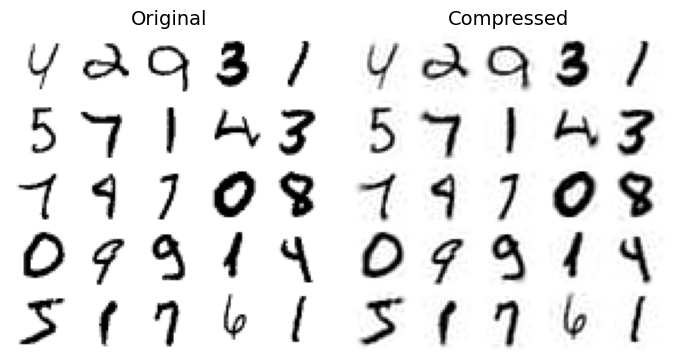

In [32]:
# extra code – this cell generates and saves Figure 8–9

plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

save_fig("mnist_compression_plot")

* After **dimensionality reduction**, the training set occupies **much less space**.

* Example using **MNIST + PCA (95% variance preserved)**:

  * Original features: **784**
  * Reduced features: **154**
  * Dataset size becomes **< 20% of the original**
  * Variance lost: **only 5%**

* This represents a **good compression ratio**:

  * Significant reduction in storage and computation
  * Minimal loss of information

* Practical impact:

  * **Classification and other ML algorithms run much faster**
  * Less memory usage
  * Faster training and inference

* PCA also supports **decompression** (approximate reconstruction):

  * Reduced data can be projected back to the **original feature space**
  * Done using the **inverse PCA transformation**

* Important limitation:

  * The original data **cannot be perfectly recovered**
  * Information lost corresponds to the **discarded variance (e.g., 5%)**

* However:

  * Reconstructed data is often **very close to the original**
  * Especially when a high variance ratio is preserved

* **Reconstruction error**:

  * Defined as the **mean squared distance** between:

    * Original data
    * Reconstructed data (after compression + decompression)
  * Measures how much information was lost due to dimensionality reduction

* Visual effect (MNIST example):

  * Reconstructed digits show:

    * Slight blurring
    * Minor loss of detail
  * Overall digit structure remains **clearly recognizable**

* PCA inverse transformation formula:

  $$X_{recovered} = X_{d_{proj}} · W_{d}^T$$

* Interpretation of the formula:

  * X₍d-proj₎:

    * Dataset projected into d-dimensional space
  * W₍d₎ᵀ:

    * Transpose of the matrix containing the first d principal components
  * Result:

    * Approximate reconstruction in the original feature space

* Key takeaway:

  * PCA offers a **trade-off between compression and information loss**
  * Higher variance preservation:

    * Larger reconstructed accuracy
    * More dimensions
  * Lower variance preservation:

    * More aggressive compression
    * Higher reconstruction error


## Randomized PCA

In [34]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [36]:
# X_reduced

* PCA can be computed using different **SVD solvers**.

* Setting `svd_solver = "randomized"` makes Scikit-Learn use **Randomized PCA**.

* Randomized PCA:

  * Uses a **stochastic (approximate) algorithm**
  * Efficiently estimates the **first d principal components**
  * Especially useful when `d ≪ n`

* Computational complexity comparison:

  * **Randomized PCA**:

    * O(m × d²) + O(d³)
  * **Full SVD**:

    * O(m × n²) + O(n³)

* Where:

  * `m` = number of training instances
  * `n` = number of original features
  * `d` = number of principal components kept

* Key implication:

  * When `d` is much smaller than `n`, **randomized PCA is dramatically faster**
  * Makes PCA feasible for very high-dimensional datasets like MNIST

* Practical example:

  * MNIST with:

    * n = 784 features
    * d = 154 components
  * Randomized PCA gives:

    * Huge speed-up
    * Very small loss in precision

* Default behavior in Scikit-Learn:

  * `svd_solver = "auto"`

* With `"auto"`:

  * Scikit-Learn **automatically chooses** the solver
  * Uses **randomized PCA** if:

    * max(m, n) > 500
    * `n_components` is an integer
    * n_components < 0.8 × min(m, n)
  * Otherwise:

    * Uses **full SVD**

* For MNIST:

  * n_components = 154
  * 0.8 × 784 ≈ 627
  * Since 154 < 627:

    * **Randomized PCA is automatically selected**
    * Even without explicitly setting `svd_solver = "randomized"`

* When to force full SVD:

  * If you want:

    * **Slightly higher numerical precision**
    * Deterministic exact decomposition
  * Set:

    * `svd_solver = "full"`

* Key takeaway:

  * **Randomized PCA** is the default, fast, and practical choice for large datasets
  * **Full SVD** trades speed for marginally better precision
  * Choice depends on:

    * Dataset size
    * Required accuracy
    * Computational constraints


## Incremental PCA

In [37]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [38]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train  # could be a loop instead, saving the data chunk by chunk
X_mmap.flush()

In [39]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

* A limitation of standard PCA:

  * The **entire training set must fit in memory**
  * This is impractical for **very large datasets**

* Solution: **Incremental PCA (IPCA)**

  * Designed to work with **mini-batches**
  * Processes data **one batch at a time**
  * Suitable for:

    * Large datasets
    * **Online learning** (data arriving continuously)

* Key idea of Incremental PCA:

  * Split the dataset into **mini-batches**
  * Update the principal components **incrementally**
  * Avoid loading the full dataset into memory

* Important API difference:

  * Use **partial_fit()** on each mini-batch
  * Do **not** use `fit()` on the whole dataset (in this mode)

* Practical workflow with mini-batches:

  * Choose number of batches (e.g., 100)
  * Loop over batches
  * Call `partial_fit()` for each batch
  * After training, call `transform()` on the full dataset

* Benefits of Incremental PCA:

  * Much lower **memory usage**
  * Enables PCA on datasets that **cannot fit into RAM**
  * Same conceptual goal as standard PCA:

    * Preserve maximum variance
    * Reduce dimensionality (e.g., to 154 dimensions)

* Alternative approach: **memory-mapped arrays (memmap)**

  * Uses NumPy’s `memmap` class
  * Stores large arrays directly on **disk**
  * Loads only the required chunks into memory when needed

* Key properties of `memmap`:

  * Behaves like a normal NumPy array
  * Only **raw binary data** is stored on disk
  * When loading:

    * You must explicitly specify **data type**
    * You must specify **array shape**
  * If shape is omitted:

    * The array defaults to **1D**

* Using Incremental PCA with memmap:

  * Data is accessed in small chunks
  * Memory consumption stays **under control**
  * Makes it possible to:

    * Call the standard `fit()` method
    * Instead of repeatedly calling `partial_fit()`

* Batch size handling:

  * Batch size is typically:

    * Total number of samples ÷ number of batches
  * Controls how much data is loaded into memory at once

* Summary of PCA scalability options:

  * **Standard PCA**:

    * Requires full dataset in memory
  * **Randomized PCA**:

    * Faster, but still computationally heavy for large d
  * **Incremental PCA**:

    * Memory-efficient
    * Works with mini-batches or disk-backed data

* Computational limitation reminder:

  * PCA complexity (even randomized):

    * O(m × d²) + O(d³)
  * Where:

    * m = number of samples
    * d = number of retained dimensions

* Implication:

  * `d` must remain **reasonably small**

* When PCA becomes impractical:

  * Datasets with:

    * Tens of thousands of features or more
    * High-dimensional data such as large images

* In such cases:

  * PCA training may be **too slow**
  * **Random projection** becomes a better alternative


# Random Projection

**Warning**: this sections will use close to 2.5 GB of RAM. If your computer runs out of memory, just reduce _m_ and _n_:

In [40]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, ε = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=ε)
d

np.int64(7300)

In [41]:
# extra code – show the equation computed by johnson_lindenstrauss_min_dim
d = int(4 * np.log(m) / (ε ** 2 / 2 - ε ** 3 / 3))
d

7300

In [42]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)  # std dev = square root of variance

X = np.random.randn(m, n)  # generate a fake dataset
X_reduced = X @ P.T

In [43]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)  # same result as above

In [44]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

In [45]:
# extra code – performance comparison between Gaussian and Sparse RP

from sklearn.random_projection import SparseRandomProjection

print("GaussianRandomProjection fit")
%timeit GaussianRandomProjection(random_state=42).fit(X)
print("SparseRandomProjection fit")
%timeit SparseRandomProjection(random_state=42).fit(X)

gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)
sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)
print("GaussianRandomProjection transform")
%timeit gaussian_rnd_proj.transform(X)
print("SparseRandomProjection transform")
%timeit sparse_rnd_proj.transform(X)

GaussianRandomProjection fit
7.11 s ± 542 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection fit
9.71 s ± 312 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GaussianRandomProjection transform
32.9 s ± 638 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection transform
10 s ± 624 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


* **Random Projection** reduces dimensionality using a **random linear projection**.

* Although it sounds unintuitive, random projections:

  * **Preserve pairwise distances with high probability**
  * Keep similar points close and dissimilar points far apart

* This guarantee comes from the **Johnson–Lindenstrauss lemma**.

* Core idea:

  * Project data from **n dimensions to d dimensions**
  * Using a **randomly generated matrix**
  * No learning from data is required

* Trade-off:

  * Dropping more dimensions:

    * Increases information loss
    * Distorts distances more
  * Goal:

    * Choose the **smallest d** that keeps distortion within a tolerance

* Johnson–Lindenstrauss bound:

  * To ensure squared distances change by at most ε (with high probability):

  $$d ≥ 4 log(m) / (½ ε² − ⅓ ε³)$$

* Important properties of the equation:

  * Depends only on:

    * m = number of instances
    * ε = tolerated distortion
  * **Does NOT depend on n** (original number of features)

* Example:

  * m = 5,000
  * n = 20,000
  * ε = 0.1 (10% distortion)
  * Required dimensions:

    * d = 7,300

* This is a **huge reduction** from 20,000 → 7,300 dimensions.

* Random projection matrix construction:

  * Shape: d × n
  * Each value sampled from:

    * Mean = 0
    * Variance = 1 / d

* Projection operation:

  * $$X_reduced = X · Pᵀ$$

* Key characteristics of random projection:

  * **Extremely fast**
  * **No training phase**
  * Only requires knowing the **shape of the dataset**
  * Data values are never inspected to learn parameters

* Scikit-Learn support:

  * **GaussianRandomProjection**

    * Automatically computes d using Johnson–Lindenstrauss bound
    * Stores the random matrix in `components_`
    * `eps` controls ε (default ε = 0.1)
    * `n_components` can be set to force a specific d

* Sparse Random Projection:

  * Uses a **sparse random matrix**
  * Same distance-preserving guarantees as Gaussian RP

* Advantages over Gaussian RP:

  * Much **lower memory usage**
  * Much **faster computation**
  * Preserves sparsity of input data
  * Comparable dimensionality reduction quality

* Memory comparison (example):

  * Gaussian RP matrix: ~1.2 GB
  * Sparse RP matrix: ~25 MB

* Sparse random matrix details:

  * Density r = ratio of nonzero elements
  * Default density:

    * r = 1 / n
  * With n = 20,000:

    * Only ~1 in 141 entries is nonzero

* Value distribution:

  * Each entry has:

    * Probability r of being nonzero
    * Value either +v or −v (equal probability)
  * Where:

    * $$v = 1 / √r$$

* Inverse transformation (approximate reconstruction):

  * Requires computing the **pseudo-inverse** of the components matrix

* Reconstruction formula:

  $$X_recovered = X_reduced · (P⁺)ᵀ$$

* Practical warning:

  * Computing the pseudo-inverse is **very expensive**
  * Time complexity:

    * O(d n²) if d < n
    * O(n d²) otherwise
  * Often impractical for large matrices

* Final takeaway:

  * Random projection is:

    * Simple
    * Fast
    * Memory-efficient
    * Surprisingly effective
  * Best suited for:

    * **Very high-dimensional datasets**
    * Large-scale or sparse data
  * **SparseRandomProjection** is usually the preferred choice in practice


>Random projection is not always used to reduce the dimensionality of large datasets. For
example, a 2017 paper⁠ by Sanjoy Dasgupta et al. showed that the brain of a fruit fly
implements an analog of random projection to map dense low-dimensional olfactory
inputs to sparse high-dimensional binary outputs: for each odor, only a small fraction of
the output neurons get activated, but similar odors activate many of the same neurons.
This is similar to a well-known algorithm called locality sensitive hashing (LSH), which is
typically used in search engines to group similar documents.


# LLE

In [46]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

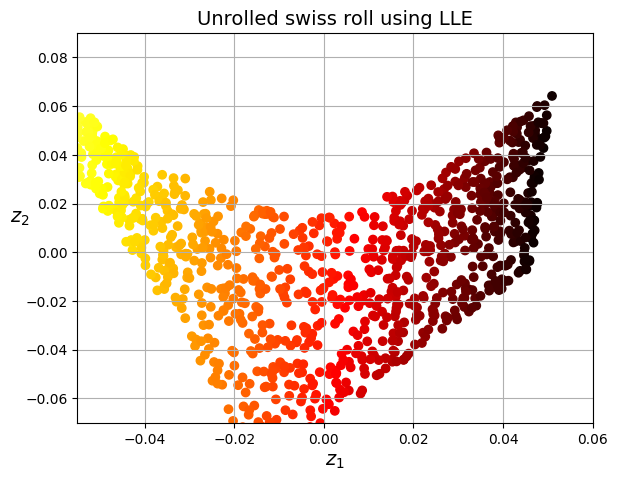

In [47]:
# extra code – this cell generates and saves Figure 8–10

plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.title("Unrolled swiss roll using LLE")
plt.show()

* **Locally Linear Embedding (LLE)** is a **nonlinear dimensionality reduction (NLDR)** technique.

* It belongs to the family of **manifold learning algorithms**.

* Unlike:

  * PCA
  * Random Projection
    LLE **does not rely on global linear projections**.

* Core idea of LLE:

  * Each data point can be **locally approximated** by a **linear combination of its nearest neighbors**
  * These **local linear relationships** are first learned in the original high-dimensional space
  * Then LLE finds a **low-dimensional embedding** that best preserves these local relationships

* Key steps conceptually:

  * For each training instance:

    * Identify its **k nearest neighbors**
    * Compute **linear weights** that reconstruct the instance from its neighbors
  * Find a low-dimensional representation:

    * That preserves these reconstruction weights as closely as possible

* Why LLE works well:

  * Focuses on **local geometry**, not global distances
  * Especially effective for:

    * **Twisted or curved manifolds**
    * Data with **low noise**

* Particularly good at:

  * **Unrolling manifolds** like the Swiss roll

* Example: **Swiss roll dataset**

  * Original data lives in **3D**
  * Intrinsic dimensionality is **2**

* LLE successfully:

  * Unrolls the Swiss roll into a **2D representation**
  * Preserves **local distances and neighborhood structure**

* Important observation about LLE embeddings:

  * **Local distances** are well preserved
  * **Global distances** are not guaranteed to be preserved

* Resulting shape:

  * The ideal unrolled Swiss roll would be a **rectangle**
  * LLE produces a **stretched and twisted band**
  * Still captures the **true manifold structure**

* Variable `t` in Swiss roll generation:

  * Represents the **position along the rolled axis**
  * Not required for LLE itself
  * Can be used as a target in **nonlinear regression tasks**

* Strengths of LLE:

  * Excellent for **nonlinear manifolds**
  * No assumption of global linearity
  * Strong performance when noise is limited

* Limitations:

  * Does not preserve **global geometry**
  * Sensitive to:

    * Choice of number of neighbors
    * Noise in the data

* Key takeaway:

  * LLE is a powerful **manifold learning** technique
  * Best used when:

    * Data lies on a **nonlinear, low-dimensional manifold**
    * Projection-based methods (like PCA) fail
  * Especially effective for **unrolling curved structures** like the Swiss roll


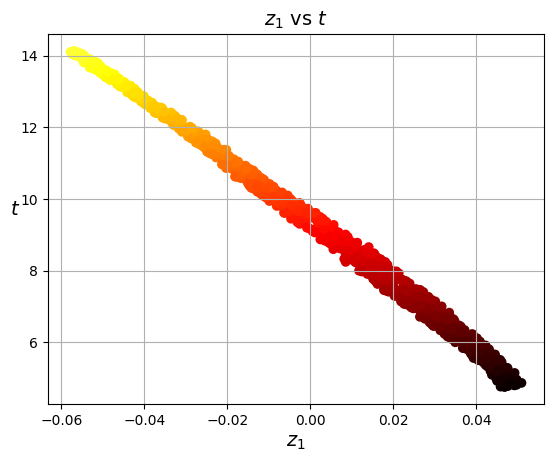

In [48]:
# extra code – shows how well correlated z1 is to t: LLE worked fine
plt.title("$z_1$ vs $t$")
plt.scatter(X_unrolled[:, 0], t, c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$t$", rotation=0)
plt.grid(True)
plt.show()

* **Locally Linear Embedding (LLE)** works in **two main steps**, both based on preserving **local relationships** rather than global structure.

* Step 1: **Model local linear relationships**

  * For each training instance x⁽ⁱ⁾:

    * Identify its **k-nearest neighbors** (k = 10 in the example)
  * Assume:

    * Each point can be **reconstructed as a linear combination of its neighbors**
  * Goal:

    * Find weights wᵢⱼ that best reconstruct x⁽ⁱ⁾ using its neighbors

* Reconstruction objective:

  * Minimize the squared reconstruction error:

  ‖ x⁽ⁱ⁾ − ∑ⱼ₌₁ᵐ wᵢⱼ x⁽ʲ⁾ ‖²

* Constraints on weights:

  * wᵢⱼ = 0 if x⁽ʲ⁾ is **not** among the k-nearest neighbors of x⁽ⁱ⁾
  * ∑ⱼ₌₁ᵐ wᵢⱼ = 1  (weight normalization)

* Optimization problem (Step 1):

  $$
\hat{W}=
\arg\min_{W}
\sum_{i=1}^{m}
\left|
x^{(i)} -
\sum_{j=1}^{m}
w_{i,j}, x^{(j)}
\right|^{2}
$$

$$
\text{subject to}
\quad
w_{i,j} = 0
;; \text{if } x^{(j)} \text{ is not one of the } k\text{-nearest neighbors of } x^{(i)}
$$

$$
\sum_{j=1}^{m} w_{i,j} = 1
\quad \text{for } i = 1,2,\ldots,m
$$


* Outcome of Step 1:

  * Weight matrix Ŵ:

    * Encodes **local linear geometry**
    * Captures how each point relates to its neighbors
    * Independent of the final embedding dimension

* Step 2: **Construct a low-dimensional embedding**

  * Map each original point x⁽ⁱ⁾ → z⁽ⁱ⁾ in a **d-dimensional space** (d < n)
  * Goal:

    * Preserve the same reconstruction relationships using the **same weights**

* Low-dimensional reconstruction objective:

  * Minimize:

  $$‖ z⁽ⁱ⁾ − ∑ⱼ₌₁ᵐ ŵᵢⱼ z⁽ʲ⁾ ‖²$$

* Optimization problem (Step 2):

  * $$Ẑ = argmin_Z ∑ᵢ₌₁ᵐ ‖ z⁽ⁱ⁾ − ∑ⱼ₌₁ᵐ ŵᵢⱼ z⁽ʲ⁾ ‖²$$

* Key difference between the two steps:

  * Step 1:

    * Data points fixed
    * Optimize **weights**
  * Step 2:

    * Weights fixed
    * Optimize **low-dimensional coordinates**

* Interpretation:

  * LLE preserves:

    * **Local neighborhood geometry**
  * LLE does **not** attempt to preserve:

    * Global distances
    * Global angles

* Computational complexity (Scikit-Learn LLE):

  * k-nearest neighbors search:

    * O(m log(m) · n log(k))
  * Weight optimization:

    * O(m n k)
  * Low-dimensional embedding construction:

    * O(d m)

* Scalability issue:

  * The **O(d m)** term limits performance
  * LLE **does not scale well to very large datasets**

* Comparison with projection methods:

  * PCA / Random Projection:

    * Global, linear
    * Simpler and faster
  * LLE:

    * Local, nonlinear
    * More complex
    * Can produce **much better embeddings** for nonlinear data

* Key takeaway:

  * LLE is:

    * Fundamentally different from projection-based methods
    * More computationally expensive
    * Extremely powerful for **nonlinear manifolds**
  * Best used when:

    * Manifold structure is strong
    * Dataset size is moderate
    * Projection methods fail to capture structure


# Other Dimensionality Reduction Techniques

* There are several **other dimensionality reduction techniques** available in Scikit-Learn, each with different goals and trade-offs.

* **Multidimensional Scaling (MDS)**:

  * Objective:

    * Reduce dimensionality while **preserving pairwise distances** between instances
  * Works well when:

    * Distance information is meaningful
  * Limitations:

    * Does **not scale well**
    * Less effective for **very high-dimensional data**
  * Contrast:

    * Random projection preserves distances better in **high-dimensional spaces**
    * MDS is more suitable for **low-dimensional settings**

* **Isomap**:

  * Core idea:

    * Build a **graph** by connecting each instance to its **nearest neighbors**
  * Dimensionality reduction goal:

    * Preserve **geodesic distances**, not straight-line (Euclidean) distances
  * Geodesic distance:

    * Length of the **shortest path in the neighbor graph**
    * Captures distances **along the manifold**
  * Strength:

    * Good at unfolding **nonlinear manifolds**
  * Weakness:

    * Can distort or lose **global structure**, depending on the data

* **t-distributed Stochastic Neighbor Embedding (t-SNE)**:

  * Objective:

    * Keep **similar instances close**
    * Push **dissimilar instances far apart**
  * Primary use case:

    * **Data visualization**
    * Especially effective for **cluster visualization**
  * Common characteristics:

    * Produces visually appealing 2D or 3D embeddings
    * Emphasizes **local structure**
  * Limitations:

    * Poor at preserving **global distances**
    * Not suitable as a preprocessing step for most ML models
  * Typical application:

    * Visualizing high-dimensional datasets like **MNIST**

* **Linear Discriminant Analysis (LDA)**:

  * Nature:

    * A **linear supervised classification algorithm**
  * During training:

    * Learns axes that **maximize class separability**
  * As a dimensionality reduction method:

    * Projects data onto directions that:

      * Keep classes **as far apart as possible**
  * Advantages:

    * Uses **label information**
    * Often better than PCA for classification tasks
  * Usage:

    * Can be used as:

      * A standalone classifier
      * A dimensionality reduction step before another classifier

* Comparative behavior on the Swiss roll:

  * **MDS**:

    * Flattens the Swiss roll
    * Preserves **global curvature**
  * **Isomap**:

    * Completely removes the roll structure
    * Loses global curvature
  * **t-SNE**:

    * Partially flattens the roll
    * Preserves some curvature
    * **Amplifies clusters**, tearing the roll apart

* Key takeaway:

  * No dimensionality reduction technique is universally best
  * The “right” method depends on:

    * Whether **local or global structure** matters
    * Whether labels are available
    * Whether the goal is **visualization or preprocessing**
    * The downstream task requirements


---

Note: I added `normalized_stress=False` below to avoid a warning about the fact that the default value for that hyperparameter will change in the future. Please see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html) for more details.

In [49]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, normalized_stress=False, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

C:\Users\roush\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\manifold\_mds.py:744: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.
  warnings.warn(
C:\Users\roush\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\manifold\_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(


In [50]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

In [51]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

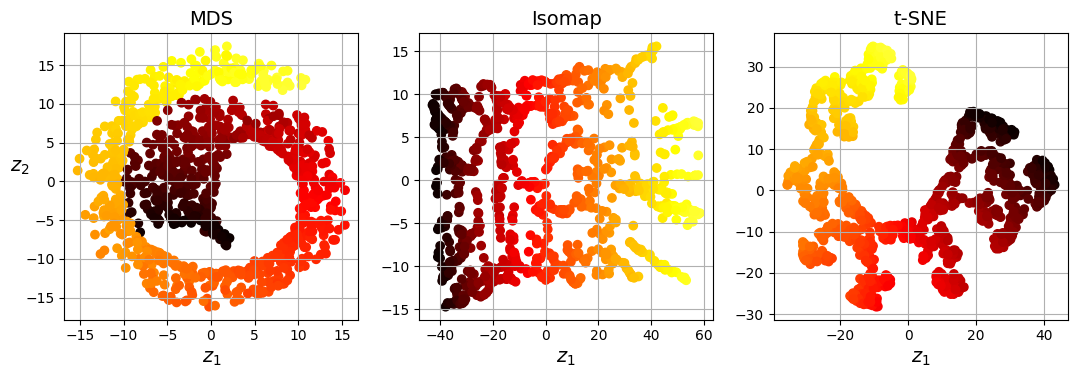

In [52]:
# extra code – this cell generates and saves Figure 8–11

titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

# Extra Material – Kernel PCA

In [53]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, random_state=42)
X_reduced = rbf_pca.fit_transform(X_swiss)

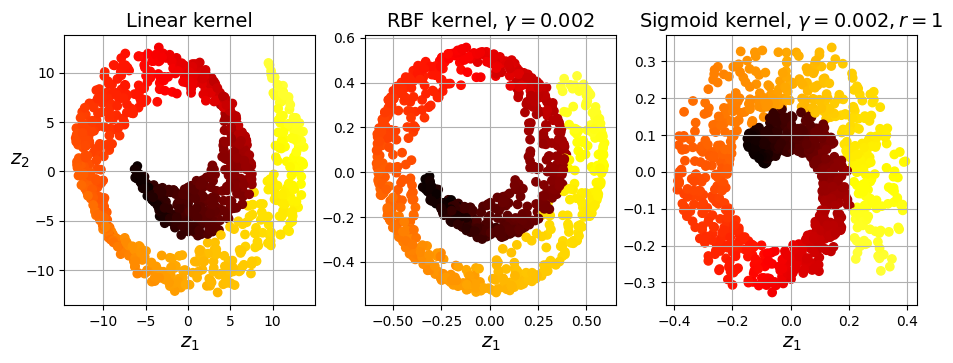

In [54]:
lin_pca = KernelPCA(kernel="linear")
rbf_pca = KernelPCA(kernel="rbf", gamma=0.002)
sig_pca = KernelPCA(kernel="sigmoid", gamma=0.002, coef0=1)

kernel_pcas = ((lin_pca, "Linear kernel"),
               (rbf_pca, rf"RBF kernel, $\gamma={rbf_pca.gamma}$"),
               (sig_pca, rf"Sigmoid kernel, $\gamma={sig_pca.gamma}, r={sig_pca.coef0}$"))

plt.figure(figsize=(11, 3.5))
for idx, (kpca, title) in enumerate(kernel_pcas):
    kpca.n_components = 2
    kpca.random_state = 42
    X_reduced = kpca.fit_transform(X_swiss)

    plt.subplot(1, 3, idx + 1)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if idx == 0:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid()

plt.show()

# Exercises

## 1. What are the main motivations for reducing a dataset’s dimensionality? What are the main drawbacks?

The main motivations for dimensionality reduction are:
    * To speed up a subsequent training algorithm (in some cases it may even remove noise and redundant features, making the training algorithm perform better)
    * To visualize the data and gain insights on the most important features
    * To save space (compression)
    
    The main drawbacks are:
    * Some information is lost, possibly degrading the performance of subsequent training algorithms.
    * It can be computationally intensive.
    * It adds some complexity to your Machine Learning pipelines.
    * Transformed features are often hard to interpret.

## 2. What is the curse of dimensionality?

The curse of dimensionality refers to the fact that many problems that do not exist in low-dimensional space arise in high-dimensional space. In Machine Learning, one common manifestation is the fact that randomly sampled high-dimensional vectors are generally far from one another, increasing the risk of overfitting and making it very difficult to identify patterns without having plenty of training data.

## 3. Once a dataset’s dimensionality has been reduced, is it possible to reverse the operation? If so, how? If not, why?

Once a dataset's dimensionality has been reduced using one of the algorithms we discussed, it is almost always impossible to perfectly reverse the operation, because some information gets lost during dimensionality reduction. Moreover, while some algorithms (such as PCA) have a simple reverse transformation procedure that can reconstruct a dataset relatively similar to the original, other algorithms (such as t-SNE) do not.

## 4. Can PCA be used to reduce the dimensionality of a highly nonlinear dataset?

PCA can be used to significantly reduce the dimensionality of most datasets, even if they are highly nonlinear, because it can at least get rid of useless dimensions. However, if there are no useless dimensions—as in the Swiss roll dataset—then reducing dimensionality with PCA will lose too much information. You want to unroll the Swiss roll, not squash it.

## 5. Suppose you perform PCA on a 1,000-dimensional dataset, setting the explained variance ratio to 95%. How many dimensions will the resulting dataset have?

That's a trick question: it depends on the dataset. Let's look at two extreme examples. First, suppose the dataset is composed of points that are almost perfectly aligned. In this case, PCA can reduce the dataset down to just one dimension while still preserving 95% of the variance. Now imagine that the dataset is composed of perfectly random points, scattered all around the 1,000 dimensions. In this case roughly 950 dimensions are required to preserve 95% of the variance. So the answer is, it depends on the dataset, and it could be any number between 1 and 950. Plotting the explained variance as a function of the number of dimensions is one way to get a rough idea of the dataset's intrinsic dimensionality.

## 6. In what cases would you use regular PCA, incremental PCA, randomized PCA, or random projection?

Regular PCA is the default, but it works only if the dataset fits in memory. Incremental PCA is useful for large datasets that don't fit in memory, but it is slower than regular PCA, so if the dataset fits in memory you should prefer regular PCA. Incremental PCA is also useful for online tasks, when you need to apply PCA on the fly, every time a new instance arrives. Randomized PCA is useful when you want to considerably reduce dimensionality and the dataset fits in memory; in this case, it is much faster than regular PCA. Finally, Random Projection is great for very high-dimensional datasets.

## 7. How can you evaluate the performance of a dimensionality reduction algorithm on your dataset?

Intuitively, a dimensionality reduction algorithm performs well if it eliminates a lot of dimensions from the dataset without losing too much information. One way to measure this is to apply the reverse transformation and measure the reconstruction error. However, not all dimensionality reduction algorithms provide a reverse transformation. Alternatively, if you are using dimensionality reduction as a preprocessing step before another Machine Learning algorithm (e.g., a Random Forest classifier), then you can simply measure the performance of that second algorithm; if dimensionality reduction did not lose too much information, then the algorithm should perform just as well as when using the original dataset.

## 8. Does it make any sense to chain two different dimensionality reduction algorithms?

It can absolutely make sense to chain two different dimensionality reduction algorithms. A common example is using PCA or Random Projection to quickly get rid of a large number of useless dimensions, then applying another much slower dimensionality reduction algorithm, such as LLE. This two-step approach will likely yield roughly the same performance as using LLE only, but in a fraction of the time.

## 9. Load the MNIST dataset (introduced in Chapter 3) and split it into atraining set and a test set (take the first 60,000 instances for training, andthe remaining 10,000 for testing). Train a random forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set. Next, use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%. Train a new random forest classifier on the reduced dataset and see how long it takes. Was training much faster? Next, evaluate the classifier on the test set. How does it compare to the previous classifier? Try again with an SGDClassifier. How much does PCA help now?

In [55]:
X_train = mnist.data[:60000]
y_train = mnist.target[:60000]

X_test = mnist.data[60000:]
y_test = mnist.target[60000:]

In [56]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [57]:
%time rnd_clf.fit(X_train, y_train)

CPU times: total: 1min 15s
Wall time: 1min 19s


RandomForestClassifier(random_state=42)

In [58]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [60]:
rnd_clf_with_pca = RandomForestClassifier(n_estimators=100, random_state=42)
%time rnd_clf_with_pca.fit(X_train_reduced, y_train)

CPU times: total: 3min 3s
Wall time: 3min 13s


RandomForestClassifier(random_state=42)

Oh no! Training is actually about twice slower now! How can that be? Well, as we saw in this chapter, dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm. See figure 8-6 (the `manifold_decision_boundary_plot*` plots above). If you try `SGDClassifier` instead of `RandomForestClassifier`, you will find that training time is reduced by a factor of 3 when using PCA. Actually, we will do this in a second, but first let's check the precision of the new random forest classifier.

In [61]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9488

It is common for performance to drop slightly when reducing dimensionality, because we do lose some potentially useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training and reduced performance. 😭

In [62]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
%time sgd_clf.fit(X_train, y_train)

CPU times: total: 4min 27s
Wall time: 4min 40s


SGDClassifier(random_state=42)

In [63]:
y_pred = sgd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8674

Okay, so the `SGDClassifier` takes much longer to train on this dataset than the `RandomForestClassifier`, plus it performs worse on the test set. But that's not what we are interested in right now, we want to see how much PCA can help `SGDClassifier`. Let's train it using the reduced dataset:

In [64]:
sgd_clf_with_pca = SGDClassifier(random_state=42)
%time sgd_clf_with_pca.fit(X_train_reduced, y_train)

CPU times: total: 56.8 s
Wall time: 59.8 s


SGDClassifier(random_state=42)

In [65]:
y_pred = sgd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.8931

So there you have it: PCA can give you a formidable speedup, and if you're lucky a performance boost... but it's really not guaranteed: it depends on the model and the dataset!

## 10. Use t-SNE to reduce the first 5,000 images of the MNIST dataset down to 2 dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image’s target class. Alternatively, you can replace each dot in the scatterplot with the corresponding instance’s class (a digit from 0 to 9), or even plot scaled down versions of the digit images themselves (if you plot all digits the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits. Try using other dimensionality reduction algorithms, such as PCA, LLE, or MDS, and compare the resulting visualizations.

In [66]:
X_sample, y_sample = X_train[:5000], y_train[:5000]

In [67]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
%time X_reduced = tsne.fit_transform(X_sample)

CPU times: total: 1min 44s
Wall time: 32.8 s


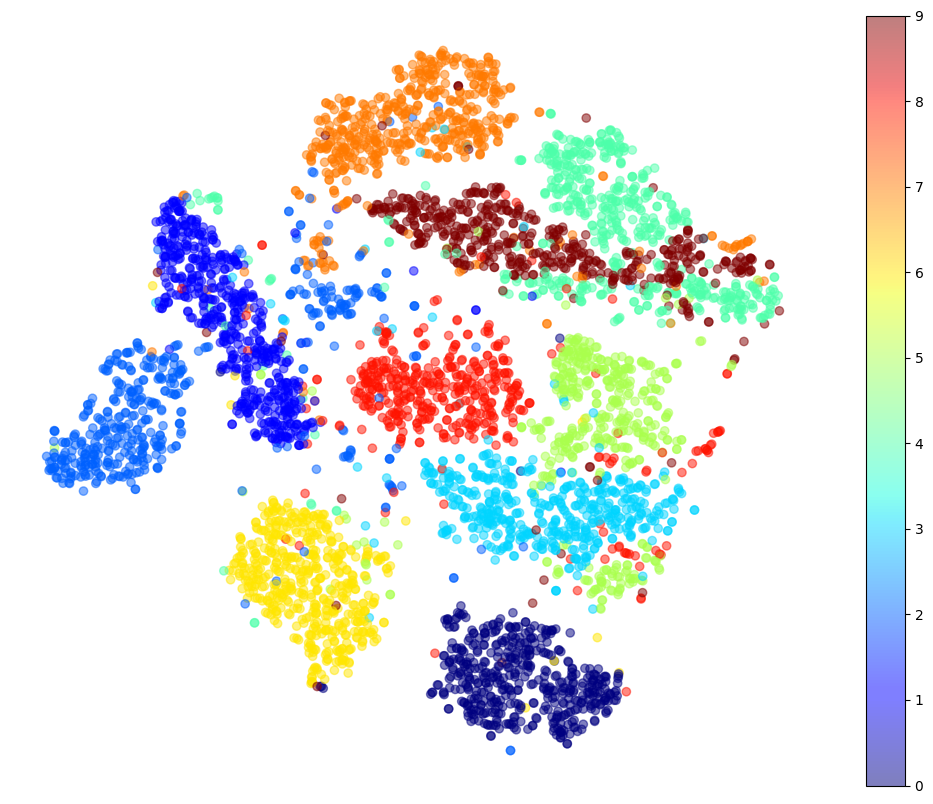

In [68]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=y_sample.astype(np.int8), cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

Isn't this just beautiful? :) Most digits are nicely separated from the others, even though t-SNE wasn't given the targets: it just identified clusters of similar images. But there is still a bit of overlap. For example, the 3s and the 5s overlap a lot (on the right side of the plot), and so do the 4s and the 9s (in the top-right corner).
lets focus on 4 and 9

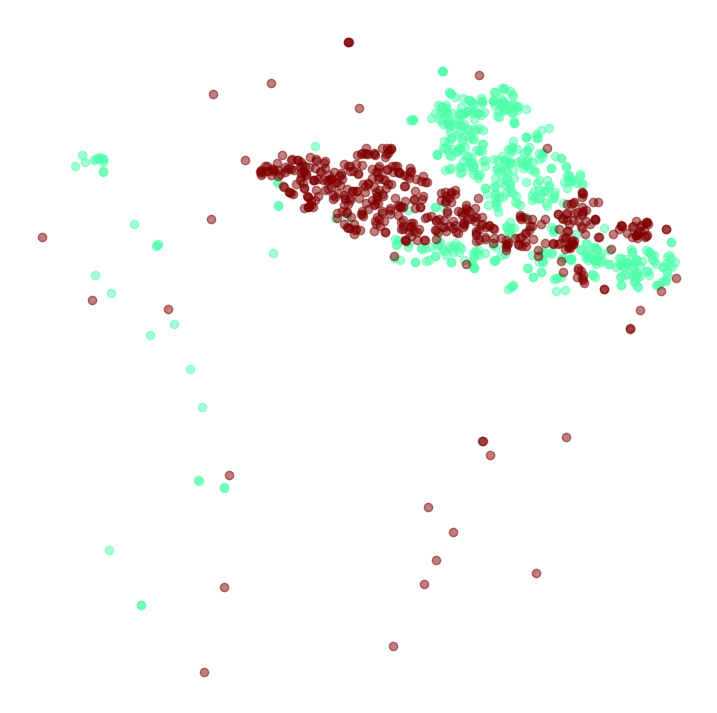

In [69]:
plt.figure(figsize=(9, 9))
cmap = plt.cm.jet
for digit in ('4', '9'):
    plt.scatter(X_reduced[y_sample == digit, 0], X_reduced[y_sample == digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis('off')
plt.show()

Let's see if we can produce a nicer image by running t-SNE on just these 2 digits:

In [70]:
idx = (y_sample == '4') | (y_sample == '9')
X_subset = X_sample[idx]
y_subset = y_sample[idx]

tsne_subset = TSNE(n_components=2, init="random", learning_rate="auto",
                   random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

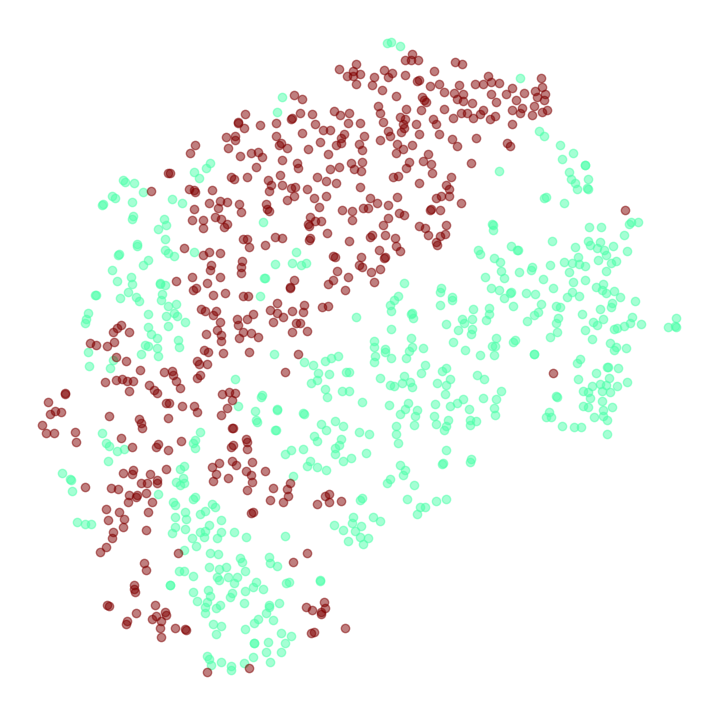

In [71]:
plt.figure(figsize=(9, 9))
for digit in ('4', '9'):
    plt.scatter(X_subset_reduced[y_subset == digit, 0],
                X_subset_reduced[y_subset == digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis('off')
plt.show()

That's much better, although there's still a bit of overlap. Perhaps some 4s really do look like 9s, and vice versa. It would be nice if we could visualize a few digits from each region of this plot, to understand what's going on. In fact, let's do that now.

Let's create a `plot_digits()` function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead. This implementation was inspired from one of Scikit-Learn's excellent examples ([plot_lle_digits](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), based on a different digit dataset).

In [72]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                    c=[cmap(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(float(y[index]) / 9),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"),
                                          image_coord)
                ax.add_artist(imagebox)

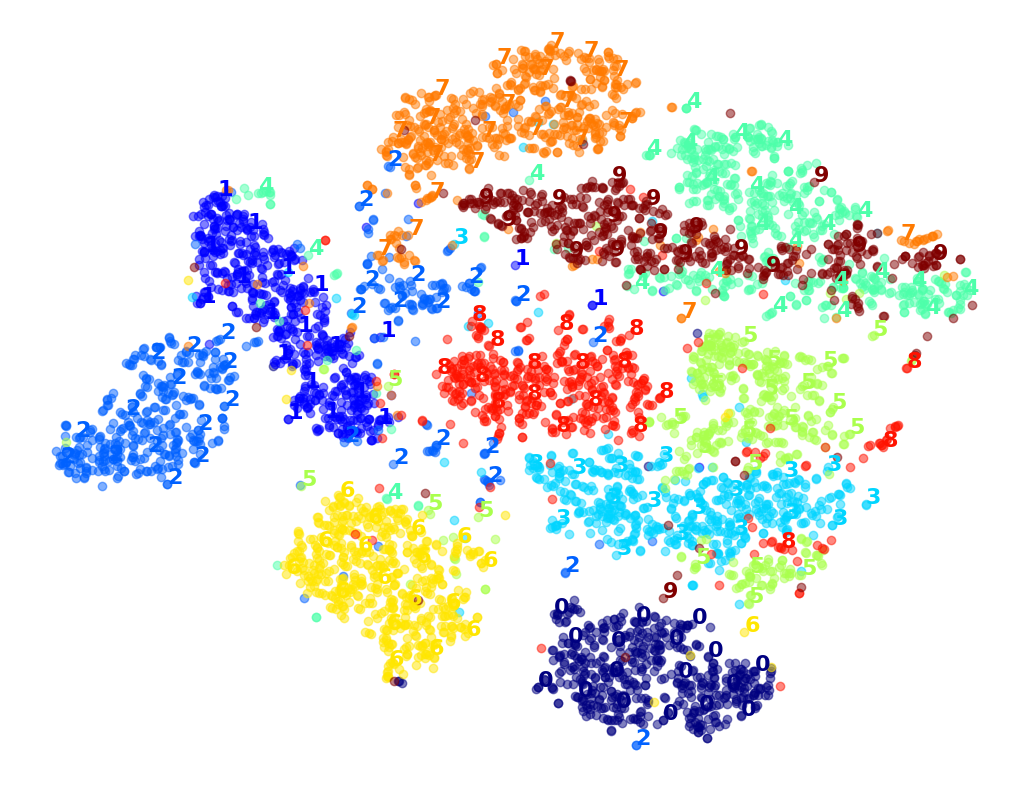

In [73]:
plot_digits(X_reduced, y_sample)

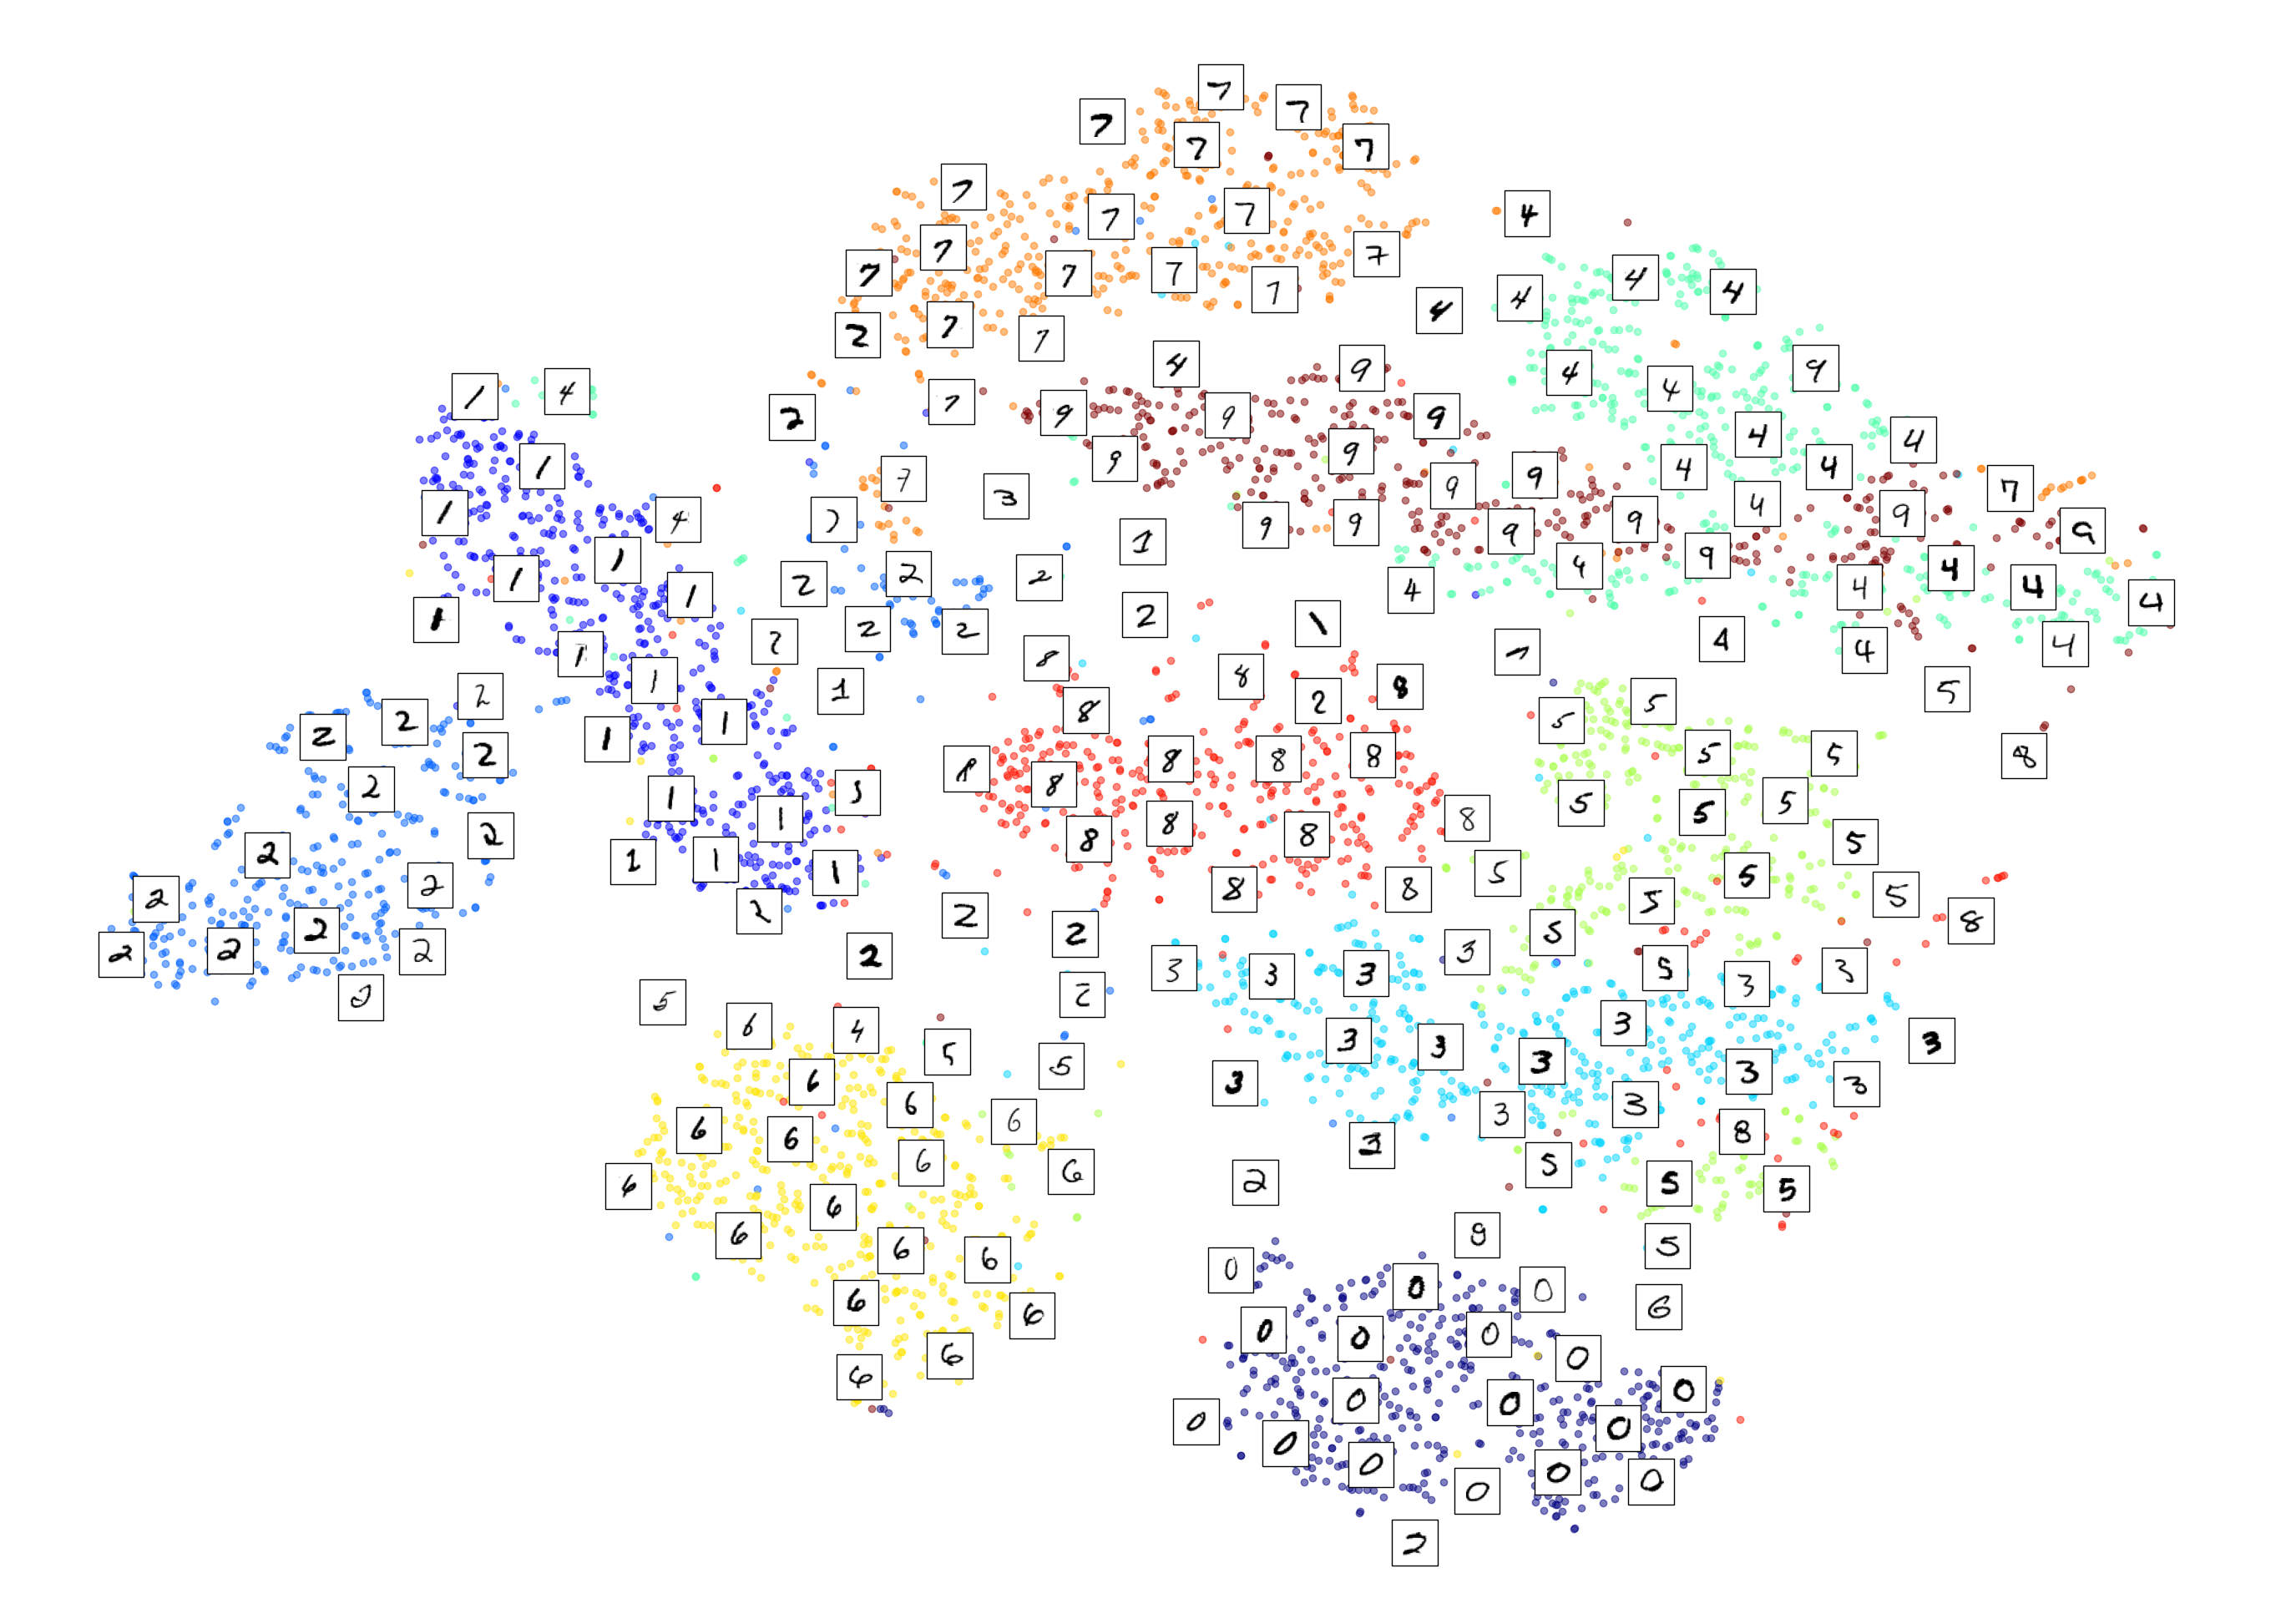

In [74]:
plot_digits(X_reduced, y_sample, images=X_sample, figsize=(35, 25))

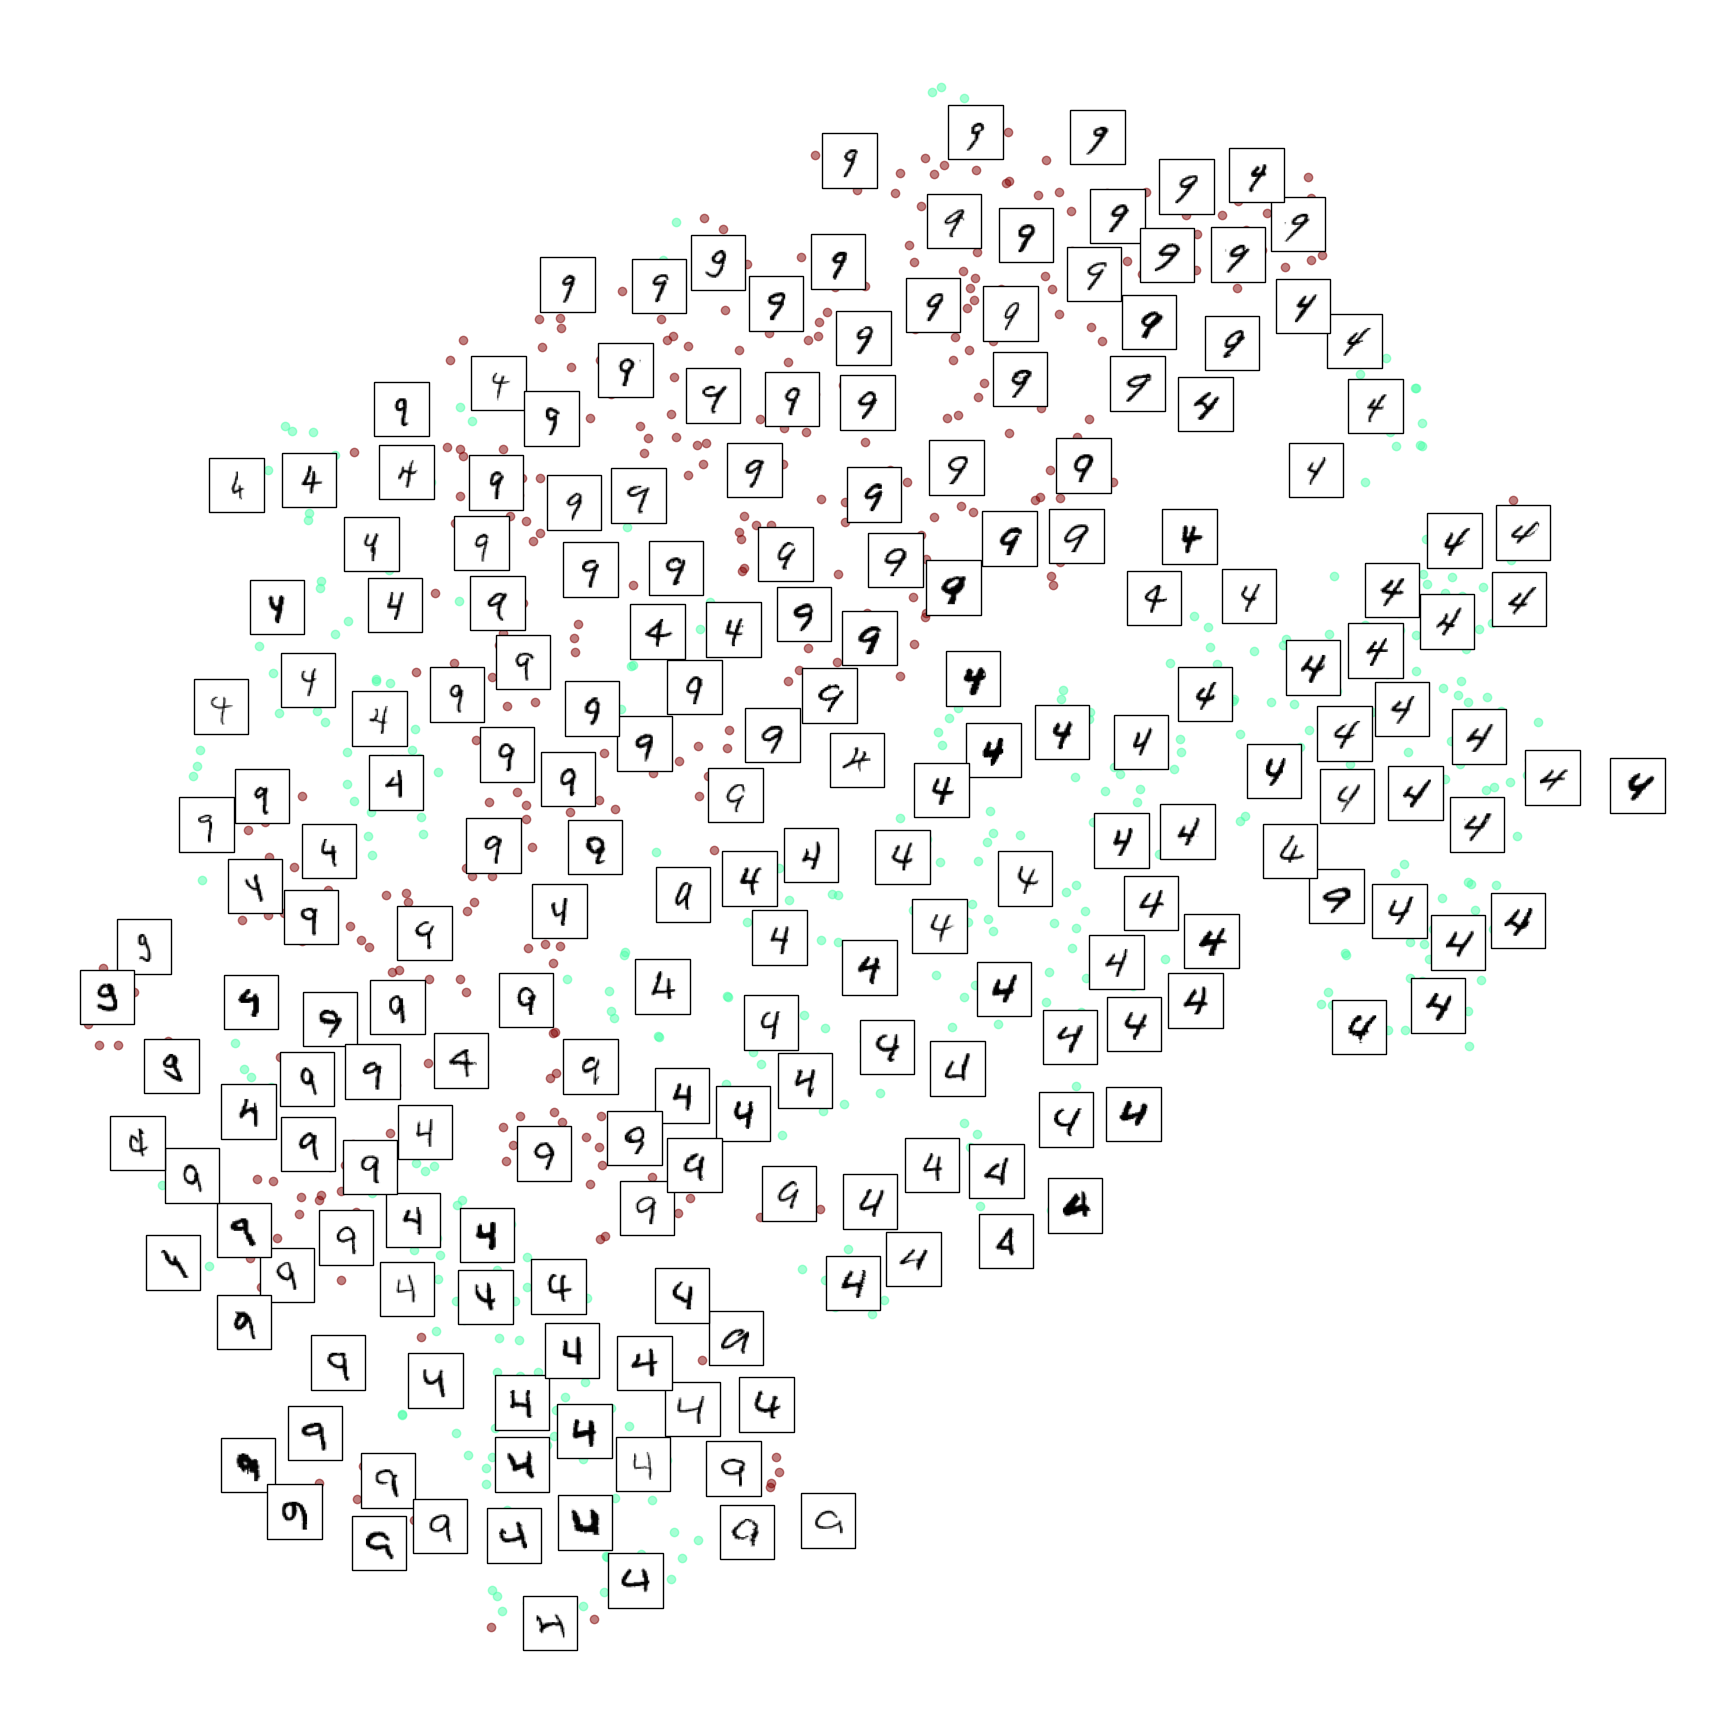

In [75]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

Notice how similar-looking 4s are grouped together. For example, the 4s get more and more inclined as they approach the top of the figure. The inclined 9s are also closer to the top. Some 4s really do look like 9s, and vice versa.

CPU times: total: 703 ms
Wall time: 270 ms


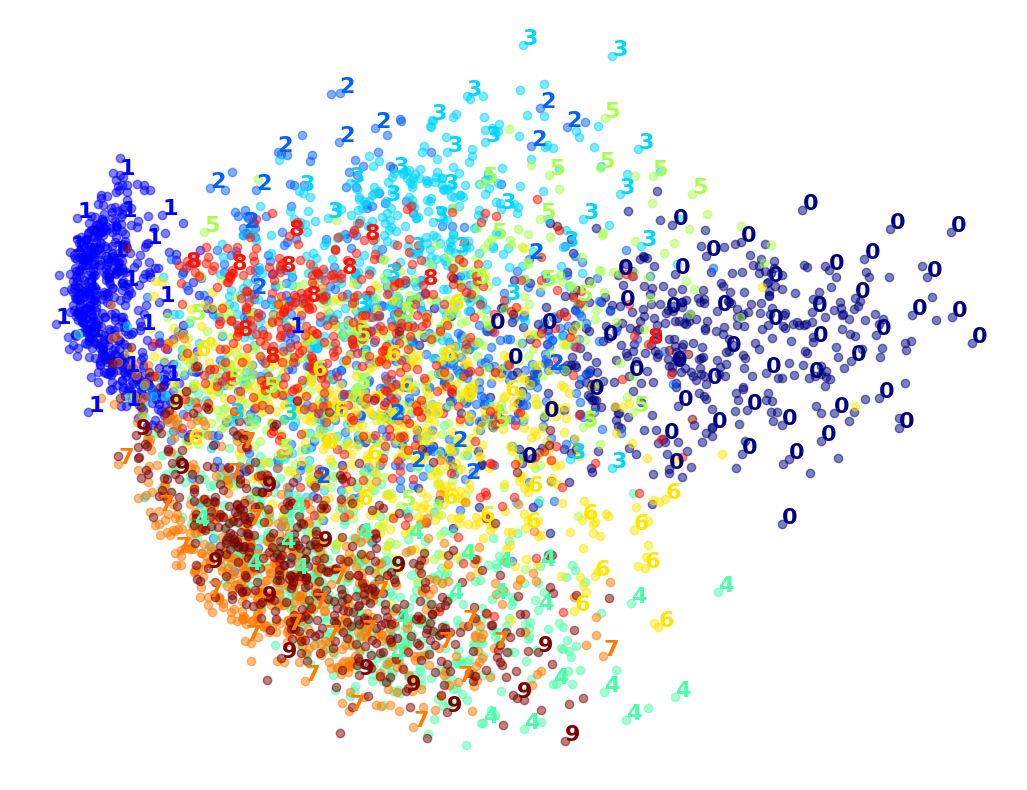

In [76]:
pca = PCA(n_components=2, random_state=42)
%time X_pca_reduced = pca.fit_transform(X_sample)
plot_digits(X_pca_reduced, y_sample)
plt.show()

CPU times: total: 7.56 s
Wall time: 4.74 s


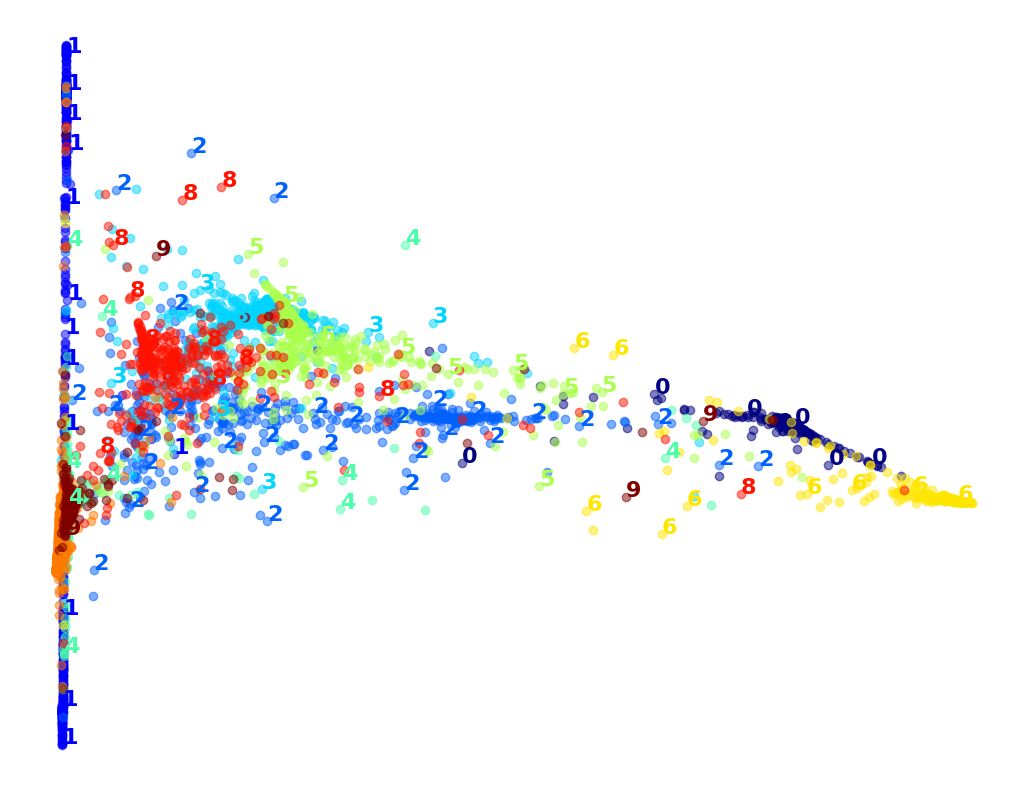

In [77]:
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
%time X_lle_reduced = lle.fit_transform(X_sample)
plot_digits(X_lle_reduced, y_sample)
plt.show()

That took more time, and yet the result does not look good at all. Let's see what happens if we apply PCA first, preserving 95% of the variance:

CPU times: total: 7.31 s
Wall time: 5.09 s


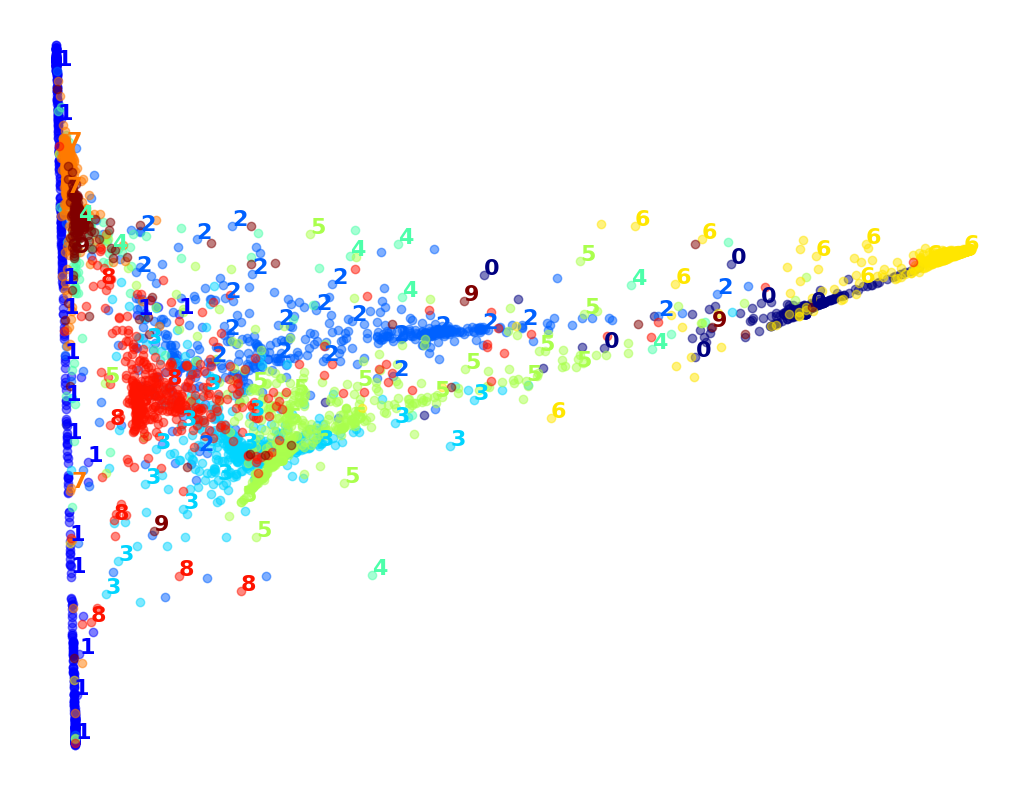

In [78]:
pca_lle = make_pipeline(PCA(n_components=0.95),
                        LocallyLinearEmbedding(n_components=2, random_state=42))

%time X_pca_lle_reduced = pca_lle.fit_transform(X_sample)
plot_digits(X_pca_lle_reduced, y_sample)
plt.show()

**Warning**, the following cell will take about 10-30 minutes to run, depending on your hardware:

In [79]:
# %time X_mds_reduced = MDS(n_components=2, normalized_stress=False, random_state=42).fit_transform(X_sample)
# plot_digits(X_mds_reduced, y_sample)
# plt.show()

In [80]:
# CPU times: user 1h 5min 8s, sys: 7min 56s, total: 1h 13min 4s

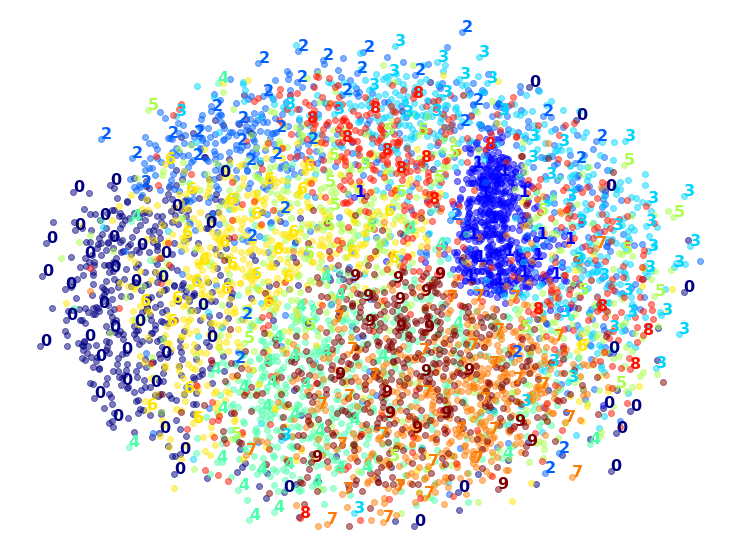

In [83]:
from IPython.display import Image, display

display(Image(filename="images/dim_reduction/X_mds_reduced.png"))

Meh. This does not look great, all clusters overlap too much. Let's try with PCA first, perhaps it will be faster?

In [84]:
# pca_mds = make_pipeline(
#     PCA(n_components=0.95, random_state=42),
#     MDS(n_components=2, normalized_stress=False, random_state=42)
# )

# %time X_pca_mds_reduced = pca_mds.fit_transform(X_sample)
# plot_digits(X_pca_mds_reduced, y_sample)
# plt.show()

In [85]:
# CPU times: user 1h 11min 58s, sys: 5min 42s, total: 1h 17min 41s

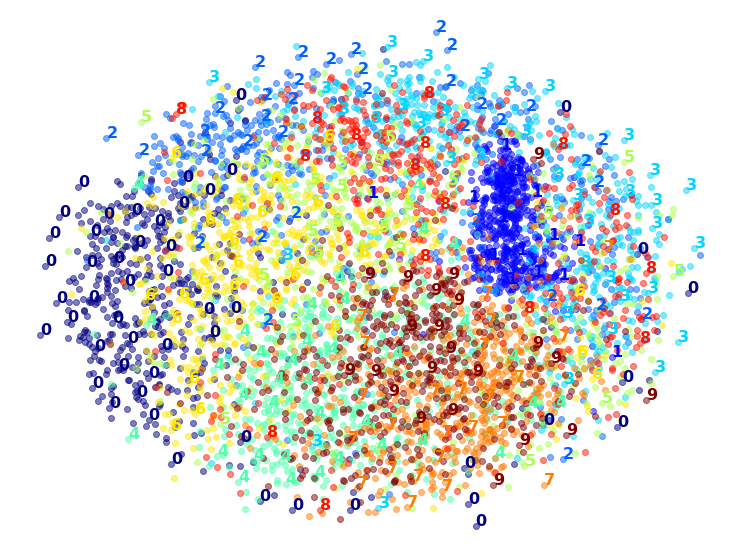

In [86]:
from IPython.display import Image, display

display(Image(filename="images/dim_reduction/X_pca_mds_reduced.png"))

CPU times: total: 3.41 s
Wall time: 1.82 s


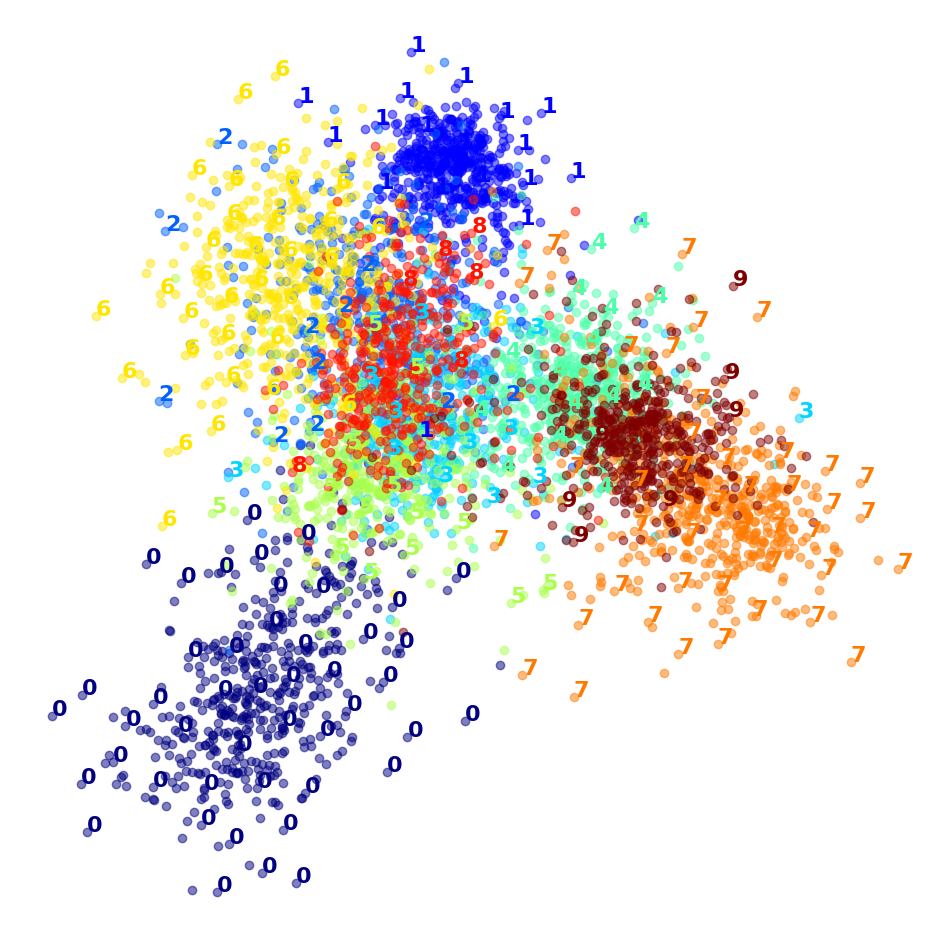

In [87]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
%time X_lda_reduced = lda.fit_transform(X_sample, y_sample)
plot_digits(X_lda_reduced, y_sample, figsize=(12, 12))
plt.show()